In [7]:
pip install sodapy


In [108]:
#!/usr/bin/env python

# make sure to install these packages before running:
# pip install pandas
# pip install sodapy

import pandas as pd
from sodapy import Socrata
import matplotlib.pyplot as plt
from datetime import datetime

class DataFetcher:
    def __init__(self, domain, app_token, dataset_id, limit=200000):
        self.client = Socrata(domain, app_token)
        self.dataset_id = dataset_id
        self.limit = limit

    def fetch_data(self):
        """
        Fetches data from the dataset and returns it as a pandas DataFrame
        """
        results = self.client.get(self.dataset_id, limit=self.limit)
        return pd.DataFrame.from_records(results)
    
    def fetch_data_with_filter(self, filter):
        """
        Fetches data from the dataset with a filter and returns it as a pandas DataFrame
        """
        results = self.client.get(self.dataset_id, where=filter, limit=self.limit)
        return pd.DataFrame.from_records(results)
    
    def list_available_options(self, column_name):
        """
        Lists the available options for a given column in the dataset
        """
        results = self.client.get(self.dataset_id, select=column_name, limit=self.limit)
        return pd.DataFrame.from_records(results)[column_name].unique()
    
    def list_available_options_with_filter(self, column_name, filter):
        """
        Lists the available options for a given column in the dataset with a filter
        """
        results = self.client.get(self.dataset_id, select=column_name, where=filter, limit=self.limit)
        return pd.DataFrame.from_records(results)[column_name].unique()
    
    def get_coordinates(self, station):
        """
        Returns the coordinates of a station
        """
        # Escape single quotes in the station name
        safe_station = station.replace("'", "''")
        results = self.client.get(self.dataset_id, where=f"nom_estacio='{safe_station}'", limit=1)
        return pd.DataFrame.from_records(results)[['nom_estacio', 'latitud', 'longitud']]


    def process_and_save_data(self, filter, output_file='filtered_data.csv'):
        """
        Fetches data from the dataset with a filter, processes it and saves it to a CSV file
        """
        results_filtered = self.fetch_data_with_filter(filter)
        results_filtered.fillna(0, inplace=True)

        new_table = pd.DataFrame(columns=results_filtered.columns)
        new_table = new_table.loc[:, ~new_table.columns.str.startswith('h')]

        melted_df = results_filtered.melt(id_vars=['data', 'nom_estacio', 'contaminant'], 
                                          value_vars=[f'h{i:02d}' for i in range(1, 25)], 
                                          var_name='hour', value_name='value')
        melted_df['hour'] = melted_df['hour'].str.extract('(\d+)').astype(int) - 1
        melted_df['data'] = pd.to_datetime(melted_df['data'])
        melted_df['data'] = melted_df.apply(lambda row: row['data'].replace(hour=row['hour']), axis=1)
        new_table = melted_df.drop(columns=['hour'])

        new_table = new_table.sort_values(by='data')

        new_table.to_csv(output_file, index=False)
        print(f"Data saved to {output_file}")
        return new_table


if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    processed_data = fetcher.process_and_save_data("municipi='Barcelona'")
    print(processed_data)
    

Data saved to filtered_data.csv
                       data                        nom_estacio contaminant  \
199994  2011-02-07 00:00:00       Barcelona (Parc Vall Hebron)         SO2   
199999  2011-02-07 00:00:00               Barcelona (Eixample)         NO2   
199998  2011-02-07 00:00:00               Barcelona (Eixample)         NOX   
199995  2011-02-07 00:00:00           Barcelona (Torre Girona)         SO2   
199996  2011-02-07 00:00:00                  Barcelona (Sants)         NOX   
...                     ...                                ...         ...   
4600017 2024-11-19 23:00:00       Barcelona (Parc Vall Hebron)          CO   
4600018 2024-11-19 23:00:00            Barcelona (Palau Reial)         NO2   
4600019 2024-11-19 23:00:00               Barcelona (Eixample)          O3   
4600021 2024-11-19 23:00:00  Barcelona (Gràcia - Sant Gervasi)         SO2   
4600038 2024-11-19 23:00:00                  Barcelona (Sants)         NO2   

        value  
199994      0  

Data saved to filtered_data.csv


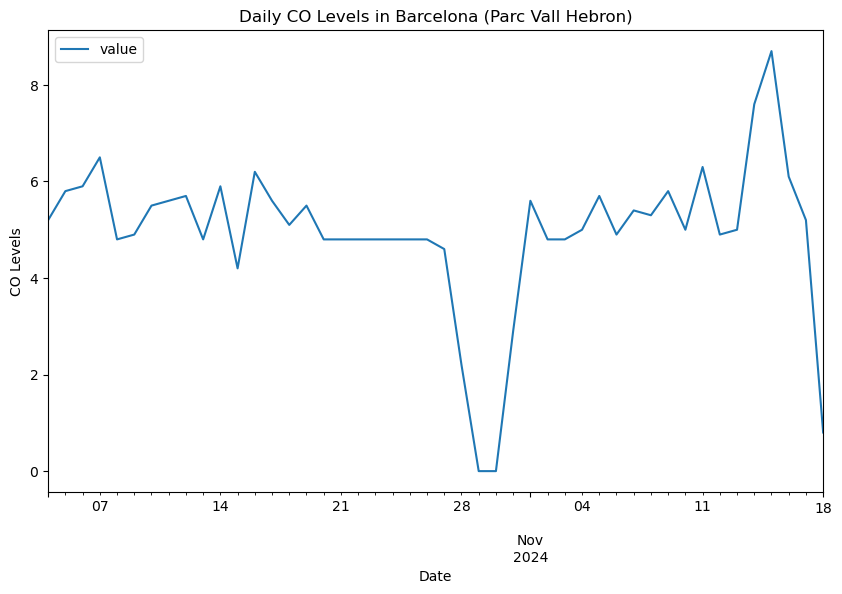

In [16]:

import matplotlib.pyplot as plt
from data_fetcher import DataFetcher
import pandas as pd

def plot_timeseries(data, title, ylabel, xlabel='Date', figsize=(10, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    data.plot(ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.savefig(f"{title}.png")
    plt.show()

def accumulate_data(data, station, contaminant, frequency):
    filtered_data = data[(data['nom_estacio'] == station) & (data['contaminant'] == contaminant)]
    numeric_data = filtered_data.drop(columns=['nom_estacio', 'contaminant'])

    numeric_data['value'] = pd.to_numeric(numeric_data['value'], errors='coerce')

    resampled = numeric_data.resample(frequency, on='data').sum()
    return resampled

if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    processed_data = fetcher.process_and_save_data("municipi='Barcelona'")

    resampled = accumulate_data(processed_data, 'Barcelona (Parc Vall Hebron)', 'CO', 'D')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Daily CO Levels in Barcelona (Parc Vall Hebron)", "CO Levels")

    
    

Data saved to filtered_data.csv


C:\Users\diogo\AppData\Local\Temp\ipykernel_9472\1166838293.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled = numeric_data.resample(frequency, on='data').sum()


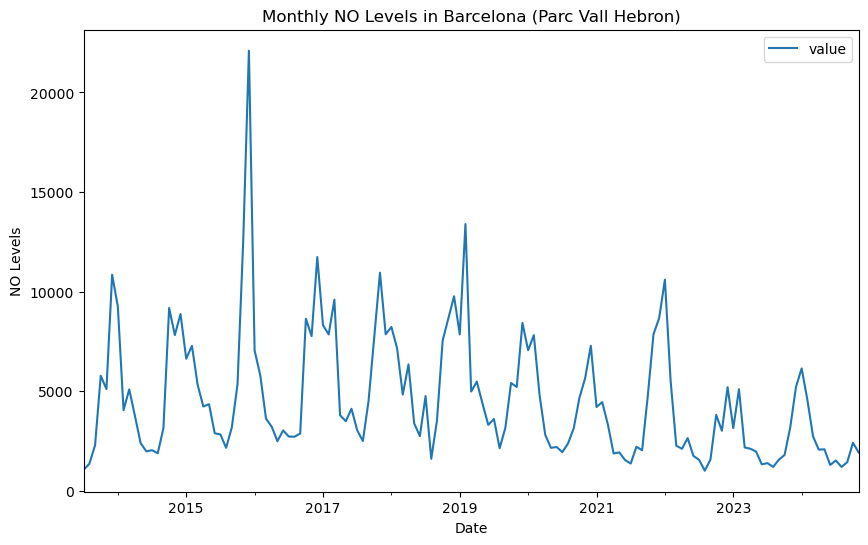

In [39]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    processed_data = fetcher.process_and_save_data("municipi='Barcelona'")

    resampled = accumulate_data(processed_data, 'Barcelona (Parc Vall Hebron)', 'NO', 'M')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Monthly NO Levels in Barcelona (Parc Vall Hebron)", "NO Levels")


Data saved to filtered_data.csv


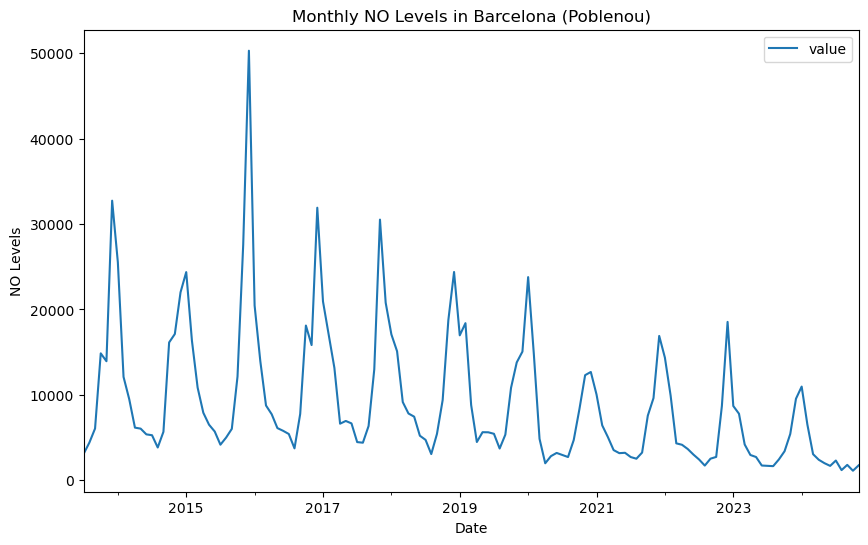

In [38]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    processed_data = fetcher.process_and_save_data("municipi='Barcelona'")

    resampled = accumulate_data(processed_data, 'Barcelona (Poblenou)', 'NO', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Monthly NO Levels in Barcelona (Poblenou)", "NO Levels")


Data saved to filtered_data.csv


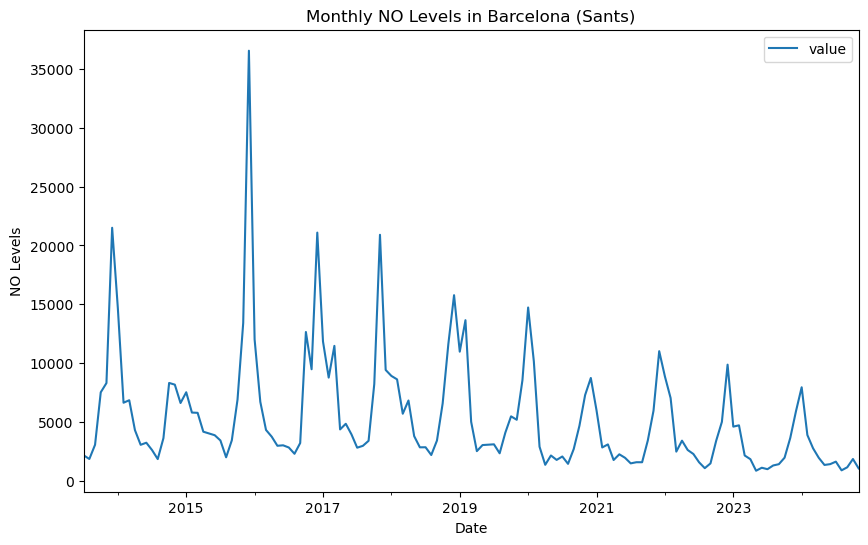

In [42]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    processed_data = fetcher.process_and_save_data("municipi='Barcelona'")

    resampled = accumulate_data(processed_data, 'Barcelona (Sants)', 'NO', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Monthly NO Levels in Barcelona (Sants)", "NO Levels")


Data saved to filtered_data.csv


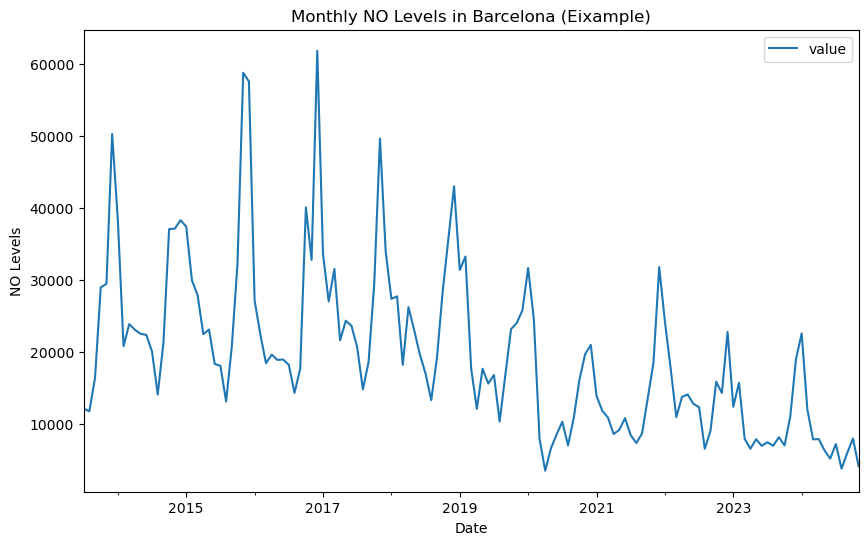

In [43]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    processed_data = fetcher.process_and_save_data("municipi='Barcelona'")

    resampled = accumulate_data(processed_data, 'Barcelona (Eixample)', 'NO', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Monthly NO Levels in Barcelona (Eixample)", "NO Levels")


Data saved to filtered_data.csv


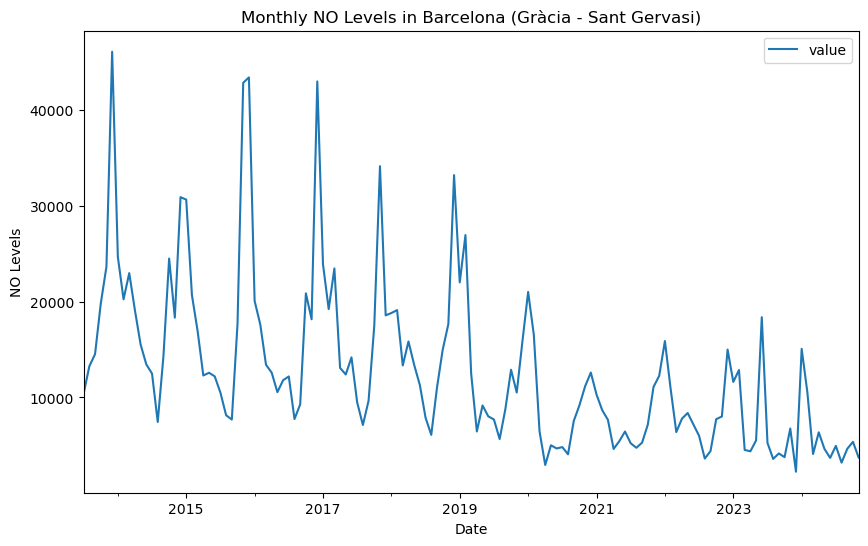

In [49]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    processed_data = fetcher.process_and_save_data("municipi='Barcelona'")

    resampled = accumulate_data(processed_data, 'Barcelona (Gràcia - Sant Gervasi)', 'NO', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Monthly NO Levels in Barcelona (Gràcia - Sant Gervasi)", "NO Levels")


Data saved to filtered_data.csv


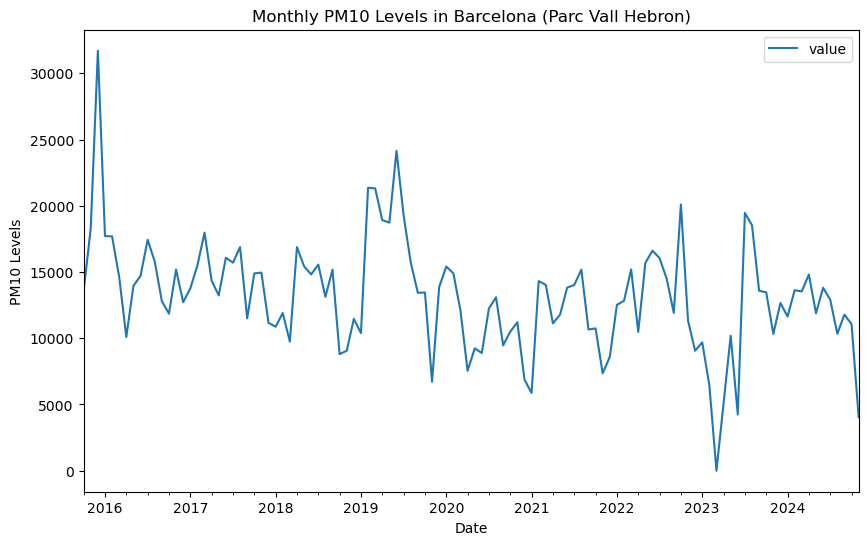

In [54]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    processed_data = fetcher.process_and_save_data("municipi='Barcelona'")

    resampled = accumulate_data(processed_data, 'Barcelona (Parc Vall Hebron)', 'PM10', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Monthly PM10 Levels in Barcelona (Parc Vall Hebron)", "PM10 Levels")

Data saved to filtered_data.csv


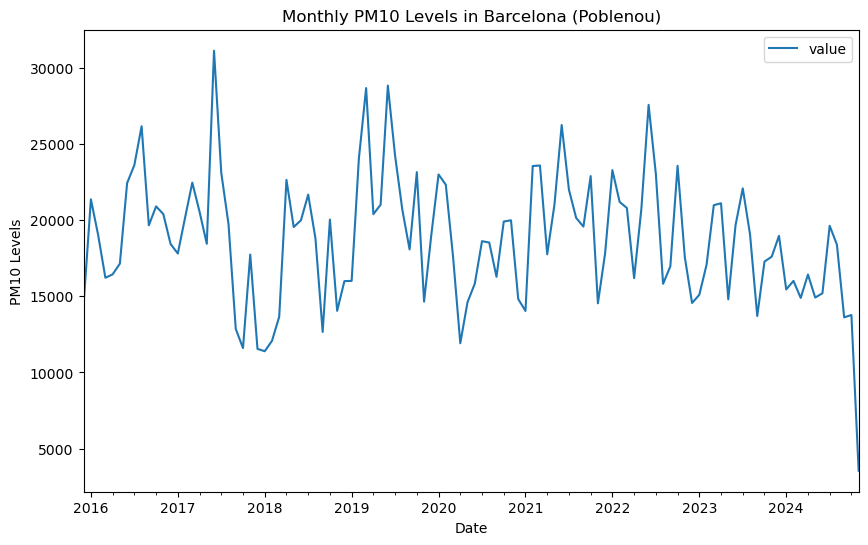

In [55]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    processed_data = fetcher.process_and_save_data("municipi='Barcelona'")

    resampled = accumulate_data(processed_data, 'Barcelona (Poblenou)', 'PM10', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Monthly PM10 Levels in Barcelona (Poblenou)", "PM10 Levels")


Data saved to filtered_data.csv


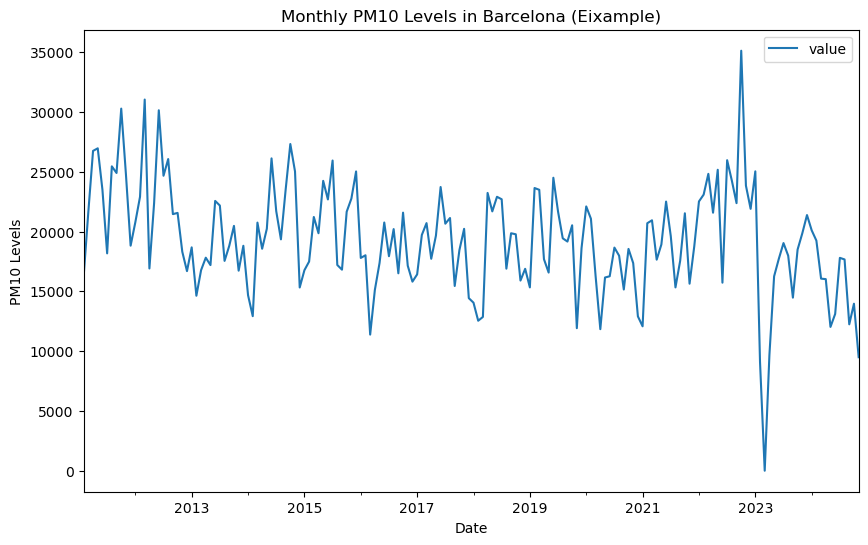

In [57]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    processed_data = fetcher.process_and_save_data("municipi='Barcelona'")

    resampled = accumulate_data(processed_data, 'Barcelona (Eixample)', 'PM10', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Monthly PM10 Levels in Barcelona (Eixample)", "PM10 Levels")


Data saved to filtered_data.csv


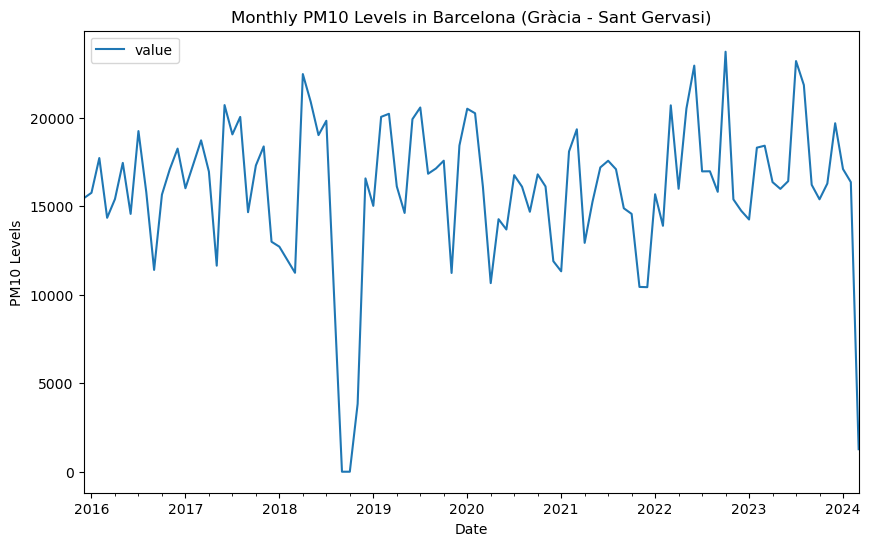

In [58]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    processed_data = fetcher.process_and_save_data("municipi='Barcelona'")

    resampled = accumulate_data(processed_data, 'Barcelona (Gràcia - Sant Gervasi)', 'PM10', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Monthly PM10 Levels in Barcelona (Gràcia - Sant Gervasi)", "PM10 Levels")


Data saved to filtered_data.csv


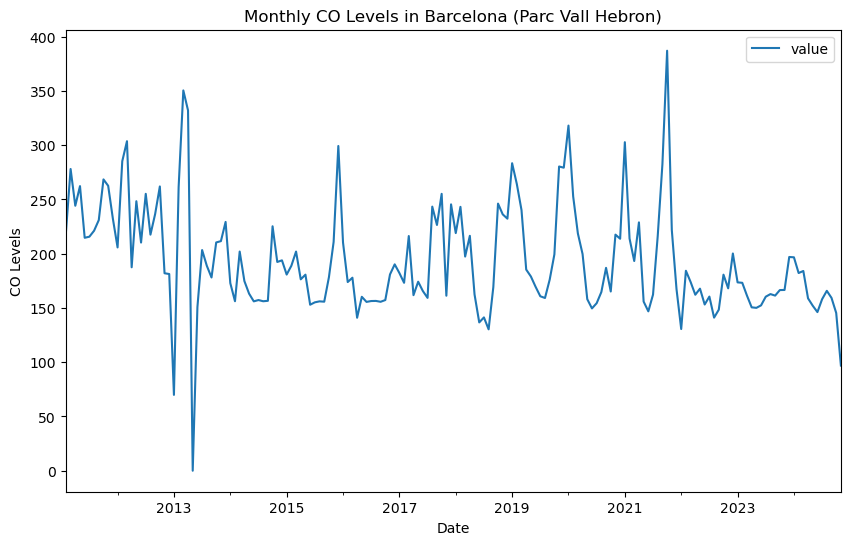

In [61]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    processed_data = fetcher.process_and_save_data("municipi='Barcelona'")

    resampled = accumulate_data(processed_data, 'Barcelona (Parc Vall Hebron)', 'CO', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Monthly CO Levels in Barcelona (Parc Vall Hebron)", "CO Levels")


Data saved to filtered_data.csv


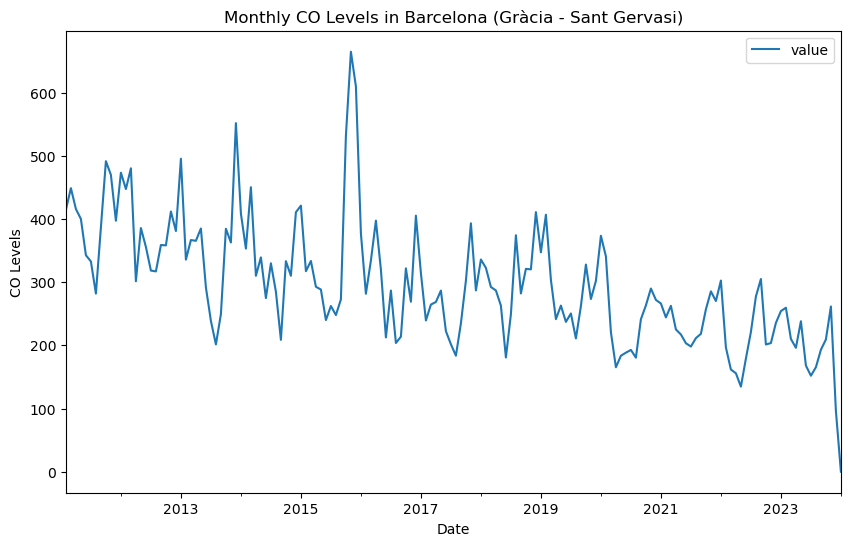

In [64]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    processed_data = fetcher.process_and_save_data("municipi='Barcelona'")

    resampled = accumulate_data(processed_data, 'Barcelona (Gràcia - Sant Gervasi)', 'CO', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Monthly CO Levels in Barcelona (Gràcia - Sant Gervasi)", "CO Levels")

Data saved to filtered_data.csv


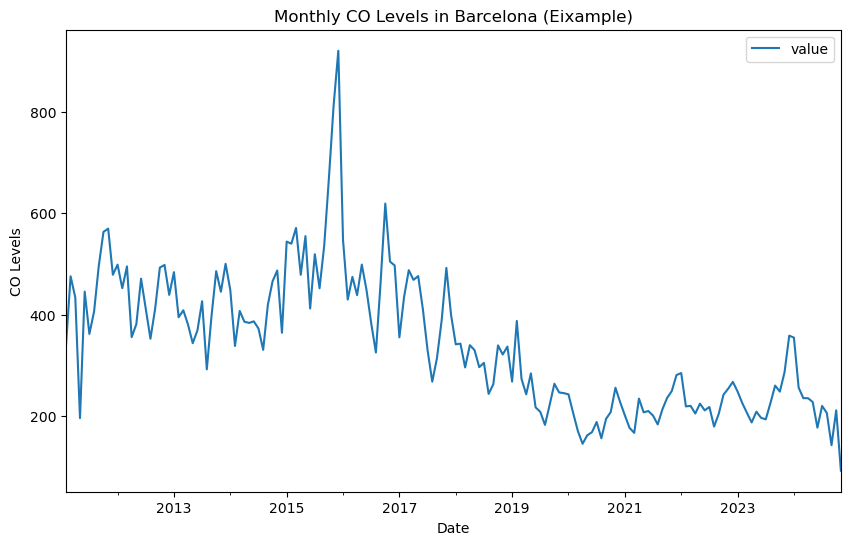

In [65]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    processed_data = fetcher.process_and_save_data("municipi='Barcelona'")

    resampled = accumulate_data(processed_data, 'Barcelona (Eixample)', 'CO', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Monthly CO Levels in Barcelona (Eixample)", "CO Levels")

Data saved to filtered_data.csv


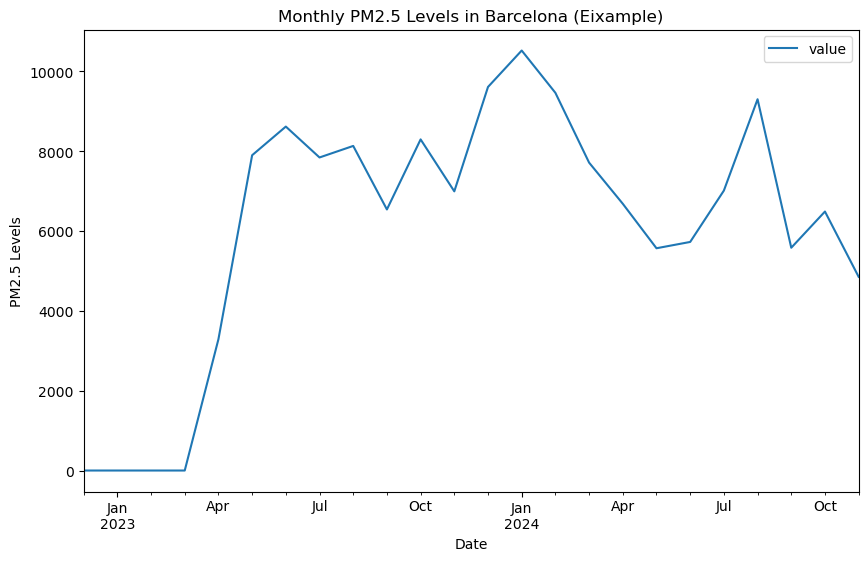

In [66]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    processed_data = fetcher.process_and_save_data("municipi='Barcelona'")

    resampled = accumulate_data(processed_data, 'Barcelona (Eixample)', 'PM2.5', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Monthly PM2.5 Levels in Barcelona (Eixample)", "PM2.5 Levels")

Data saved to filtered_data.csv


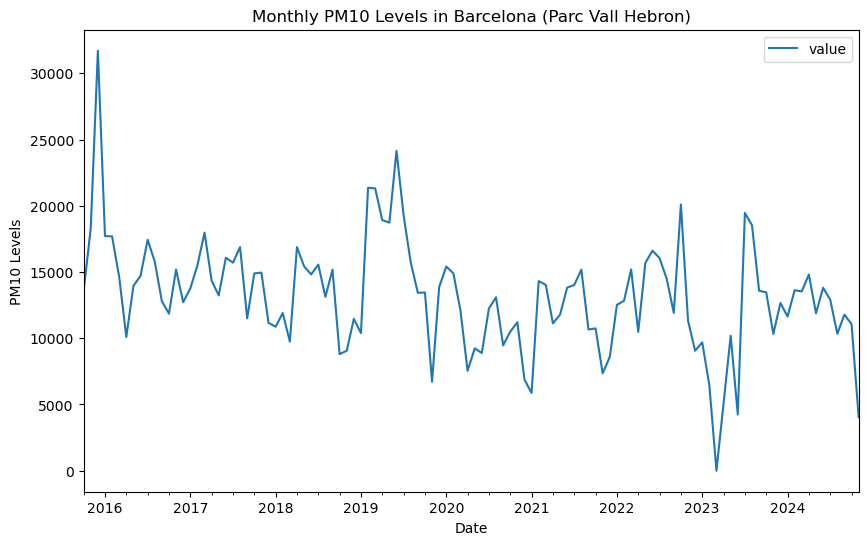

In [67]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    processed_data = fetcher.process_and_save_data("municipi='Barcelona'")

    resampled = accumulate_data(processed_data, 'Barcelona (Parc Vall Hebron)', 'PM10', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Monthly PM10 Levels in Barcelona (Parc Vall Hebron)", "PM10 Levels")


Data saved to filtered_data.csv


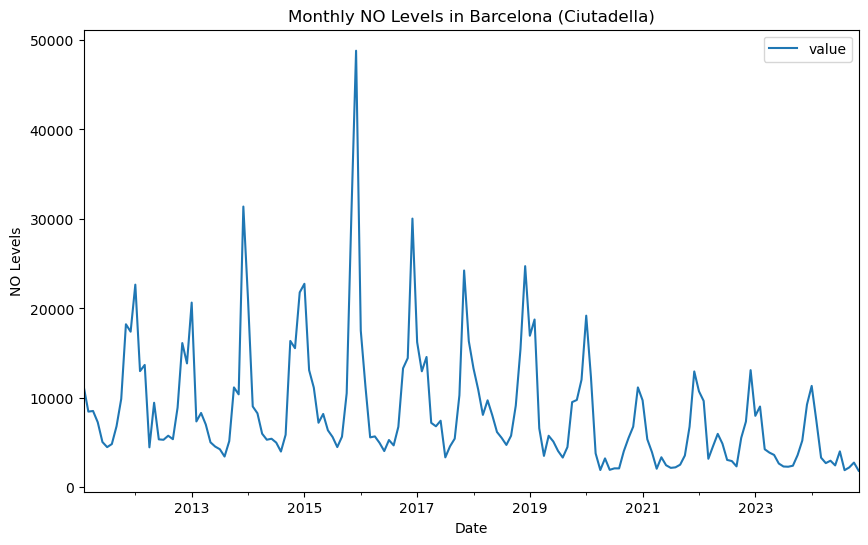

In [70]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    processed_data = fetcher.process_and_save_data("municipi='Barcelona'")

    resampled = accumulate_data(processed_data, 'Barcelona (Ciutadella)', 'NO', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Monthly NO Levels in Barcelona (Ciutadella)", "NO Levels")


In [74]:
from data_fetcher import DataFetcher
fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
#results_df = fetcher.fetch_data()
#results_filtered = fetcher.fetch_data_with_filter("municipi='Barcelona'")
available_stations = fetcher.list_available_options_with_filter("nom_estacio", "municipi='Barcelona'")
print(available_stations)

['Barcelona (Gràcia - Sant Gervasi)' 'Barcelona (Eixample)'
 'Barcelona (Observatori Fabra)' 'Barcelona (Parc Vall Hebron)'
 'Barcelona (Ciutadella)' 'Barcelona (Sants)' 'Barcelona (Palau Reial)'
 'Barcelona (Poblenou)']


Data saved to filtered_data.csv


C:\Users\diogo\AppData\Local\Temp\ipykernel_9472\1166838293.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled = numeric_data.resample(frequency, on='data').sum()


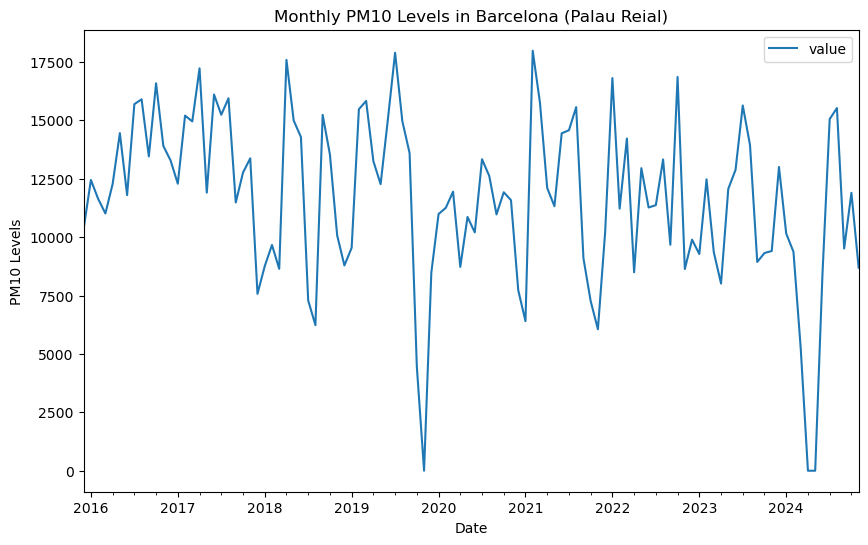

In [88]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    processed_data = fetcher.process_and_save_data("municipi='Barcelona'")

    resampled = accumulate_data(processed_data, 'Barcelona (Palau Reial)', 'PM10', 'M')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Monthly PM10 Levels in Barcelona (Palau Reial)", "PM10 Levels")

Data saved to filtered_data.csv


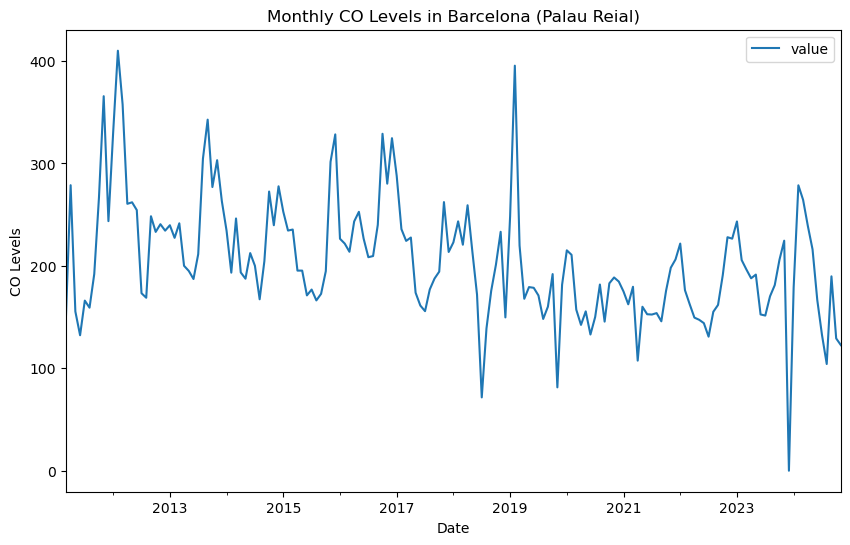

In [89]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    processed_data = fetcher.process_and_save_data("municipi='Barcelona'")

    resampled = accumulate_data(processed_data, 'Barcelona (Palau Reial)', 'CO', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Monthly CO Levels in Barcelona (Palau Reial)", "CO Levels")


Data saved to filtered_data.csv


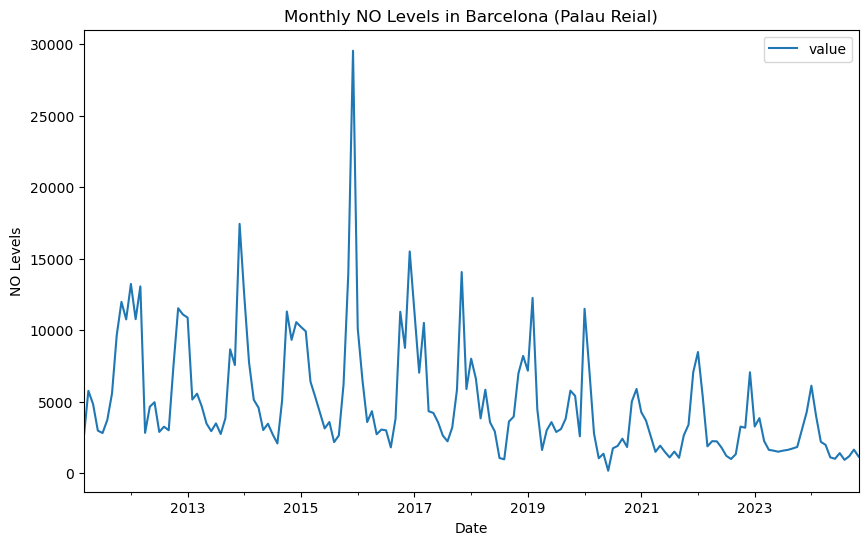

In [90]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    processed_data = fetcher.process_and_save_data("municipi='Barcelona'")

    resampled = accumulate_data(processed_data, 'Barcelona (Palau Reial)', 'NO', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Monthly NO Levels in Barcelona (Palau Reial)", "NO Levels")


Data saved to filtered_data.csv


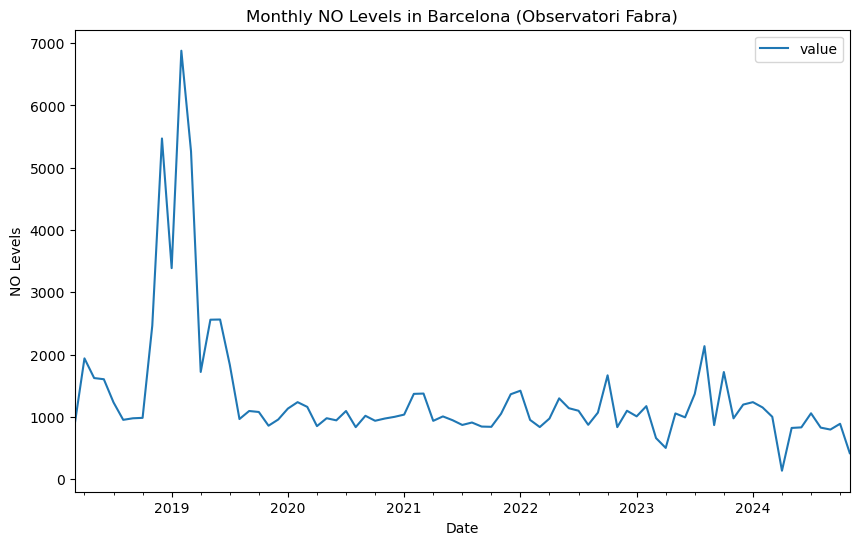

In [91]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    processed_data = fetcher.process_and_save_data("municipi='Barcelona'")

    resampled = accumulate_data(processed_data, 'Barcelona (Observatori Fabra)', 'NO', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Monthly NO Levels in Barcelona (Observatori Fabra)", "NO Levels")


In [ ]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    processed_data = fetcher.process_and_save_data("municipi='Barcelona'")

    resampled = accumulate_data(processed_data, 'Barcelona (Sants)', 'NO', '')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Monthly NO Levels in Barcelona (Sants)", "NO Levels")

    

Data saved to filtered_data.csv


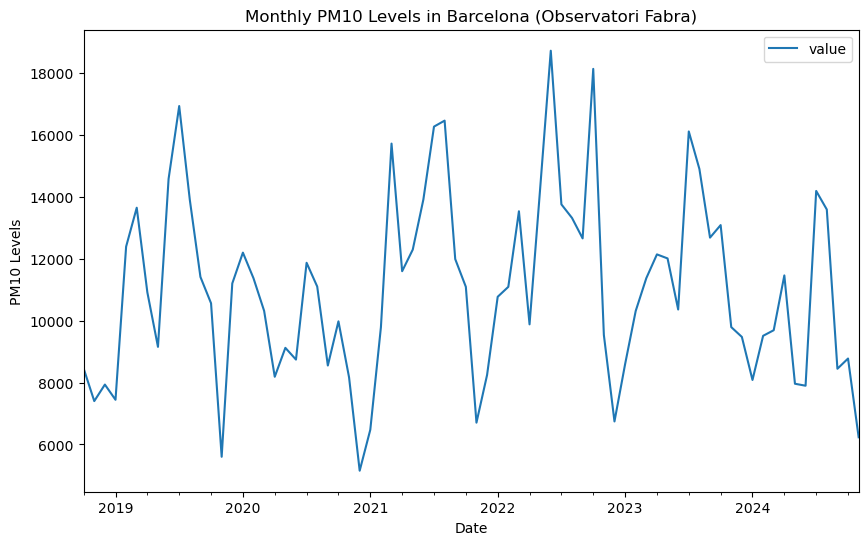

In [93]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    processed_data = fetcher.process_and_save_data("municipi='Barcelona'")

    resampled = accumulate_data(processed_data, 'Barcelona (Observatori Fabra)', 'PM10', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Monthly CO Levels in Barcelona (Observatori Fabra)", "PM10 Levels")


Data saved to data_from_barcelona.csv
                    data                   nom_estacio contaminant value
3754 2024-10-10 01:00:00          Barcelona (Poblenou)         NOX     5
3722 2024-10-10 01:00:00  Barcelona (Parc Vall Hebron)          O3    66
3721 2024-10-10 01:00:00  Barcelona (Parc Vall Hebron)         NO2     5
3720 2024-10-10 01:00:00  Barcelona (Parc Vall Hebron)          NO     1
3762 2024-10-10 01:00:00       Barcelona (Palau Reial)         SO2     1


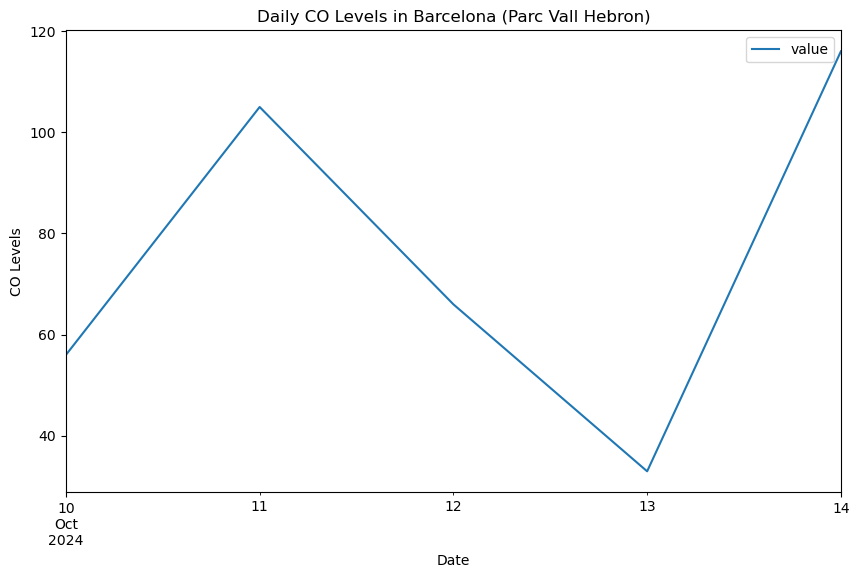

           data                   nom_estacio contaminant value
1978 2024-10-04             Barcelona (Sants)         NO2    10
1999 2024-10-04       Barcelona (Palau Reial)         SO2     2
1998 2024-10-04             Barcelona (Sants)         NOX    11
1997 2024-10-04        Barcelona (Ciutadella)         NOX    43
1996 2024-10-04  Barcelona (Parc Vall Hebron)          CO   0.2
            value
data             
2024-10-10     56
2024-10-11    105
2024-10-12     66
2024-10-13     33
2024-10-14    116


In [102]:
import matplotlib.pyplot as plt
from data_fetcher import DataFetcher
import pandas as pd

def plot_timeseries(data, title, ylabel, xlabel='Date', figsize=(10, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    data.plot(ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.savefig(f"{title}.png")
    plt.show()

def accumulate_data(data, station, contaminant, frequency):
    filtered_data = data[(data['nom_estacio'] == station) & (data['contaminant'] == contaminant)]
    numeric_data = filtered_data.drop(columns=['nom_estacio', 'contaminant'])

    numeric_data['value'] = pd.to_numeric(numeric_data['value'], errors='coerce')
    
    resampled = numeric_data.resample(frequency, on='data').sum()
    return resampled

if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    #processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2024-10-10') & (processed_data['data'] < '2024-10-15')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Parc Vall Hebron)', 'NO', 'D')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Daily CO Levels in Barcelona (Parc Vall Hebron)", "CO Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                    nom_estacio contaminant value
201760 2024-10-10 01:00:00        Barcelona (Palau Reial)          CO   0.1
201726 2024-10-10 01:00:00  Barcelona (Observatori Fabra)          O3    71
201758 2024-10-10 01:00:00           Barcelona (Eixample)         SO2     1
201736 2024-10-10 01:00:00           Barcelona (Eixample)        PM10     8
201735 2024-10-10 01:00:00   Barcelona (Parc Vall Hebron)         NO2     5


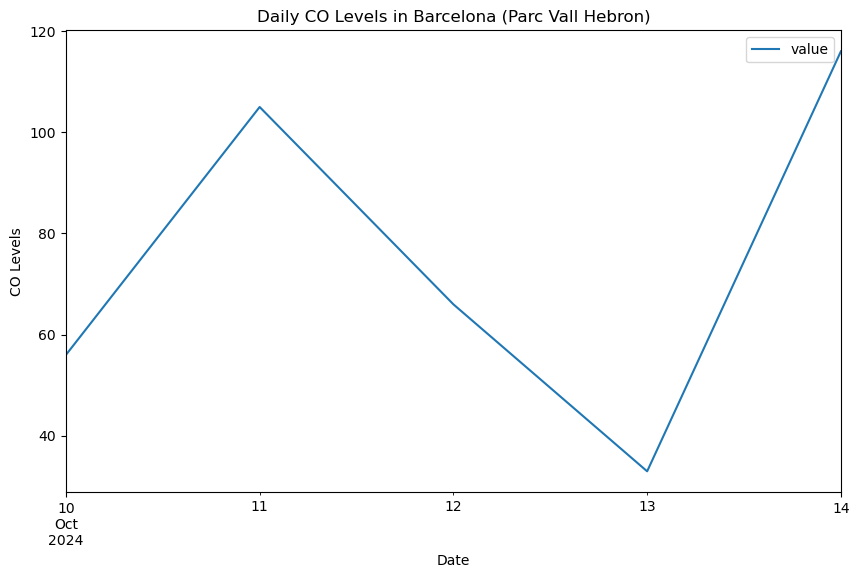

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2024-10-10     56
2024-10-11    105
2024-10-12     66
2024-10-13     33
2024-10-14    116


In [299]:
import matplotlib.pyplot as plt
from data_fetcher import DataFetcher
import pandas as pd

def plot_timeseries(data, title, ylabel, xlabel='Date', figsize=(10, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    data.plot(ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.savefig(f"{title}.png")
    plt.show()
def plot_timeseries_2(data, data_2, title, ylabel, xlabel='Date', figsize=(10, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    data.plot(ax=ax)
    data_2.plot(ax=ax)
    ax.axhline(y=200000, color='r', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
    plt.savefig(f"{title}.png")
    plt.show()
def plot_timeseries_6(data, data_2, data_3, data_4, data_5, data_6, title, ylabel, xlabel='Date', figsize=(10, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    data.plot(ax=ax)
    data_2.plot(ax=ax)
    data_3.plot(ax=ax)
    data_4.plot(ax=ax)
    data_5.plot(ax=ax)
    data_6.plot(ax=ax)
    ax.axhline(y=40, color='k', linestyle='--',label="EU limit values")
    #ax.axhline(y=20, color='y', linestyle='--',label="EU limit values(2030)")
    #ax.axhline(y=15, color='g', linestyle='--',label="WHO guidelines")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
    plt.savefig(f"{title}.png")
    plt.show()
def plot_timeseries_8(data, data_2, data_3, data_4, data_5, data_6, data_7, data_8, title, ylabel, xlabel='Date', figsize=(10, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    data.plot(ax=ax)
    data_2.plot(ax=ax)
    data_3.plot(ax=ax)
    data_4.plot(ax=ax)
    data_5.plot(ax=ax)
    data_6.plot(ax=ax)
    data_7.plot(ax=ax)
    data_8.plot(ax=ax)
    ax.axhline(y=40, color='k', linestyle='--',label="EU limit values")
    #ax.axhline(y=20, color='y', linestyle='--',label="EU limit values(2030)")
    #ax.axhline(y=10, color='g', linestyle='--',label="WHO guidelines")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
    plt.savefig(f"{title}.png")
    plt.show()
def accumulate_data(data, station, contaminant, frequency):
    filtered_data = data[(data['nom_estacio'] == station) & (data['contaminant'] == contaminant)]
    numeric_data = filtered_data.drop(columns=['nom_estacio', 'contaminant'])

    numeric_data['value'] = pd.to_numeric(numeric_data['value'], errors='coerce')
    
    resampled = numeric_data.resample(frequency, on='data').sum()
    return resampled

if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2024-10-10') & (processed_data['data'] < '2024-10-15')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Parc Vall Hebron)', 'NO', 'D')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Daily CO Levels in Barcelona (Parc Vall Hebron)", "CO Levels")
    print(processed_data.head())
    print(resampled.head())

                    data                   nom_estacio contaminant value
3754 2024-10-10 01:00:00          Barcelona (Poblenou)         NOX     5
3722 2024-10-10 01:00:00  Barcelona (Parc Vall Hebron)          O3    66
3721 2024-10-10 01:00:00  Barcelona (Parc Vall Hebron)         NO2     5
3720 2024-10-10 01:00:00  Barcelona (Parc Vall Hebron)          NO     1
3762 2024-10-10 01:00:00       Barcelona (Palau Reial)         SO2     1


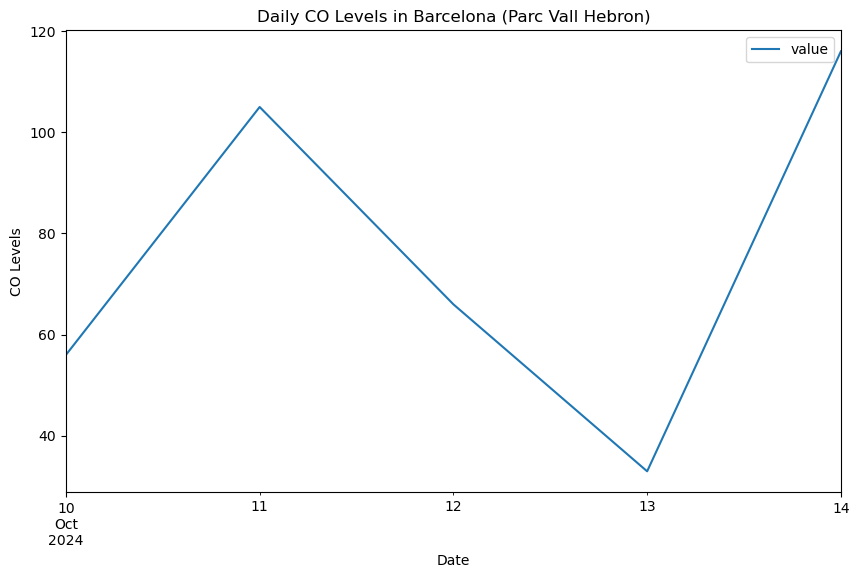

           data                   nom_estacio contaminant value
1978 2024-10-04             Barcelona (Sants)         NO2    10
1999 2024-10-04       Barcelona (Palau Reial)         SO2     2
1998 2024-10-04             Barcelona (Sants)         NOX    11
1997 2024-10-04        Barcelona (Ciutadella)         NOX    43
1996 2024-10-04  Barcelona (Parc Vall Hebron)          CO   0.2
            value
data             
2024-10-10     56
2024-10-11    105
2024-10-12     66
2024-10-13     33
2024-10-14    116


In [106]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2024-10-10') & (processed_data['data'] < '2024-10-15')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Parc Vall Hebron)', 'NO', 'D')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Daily CO Levels in Barcelona (Parc Vall Hebron)", "CO Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


C:\Users\diogo\AppData\Local\Temp\ipykernel_9472\2117806361.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled = numeric_data.resample(frequency, on='data').sum()


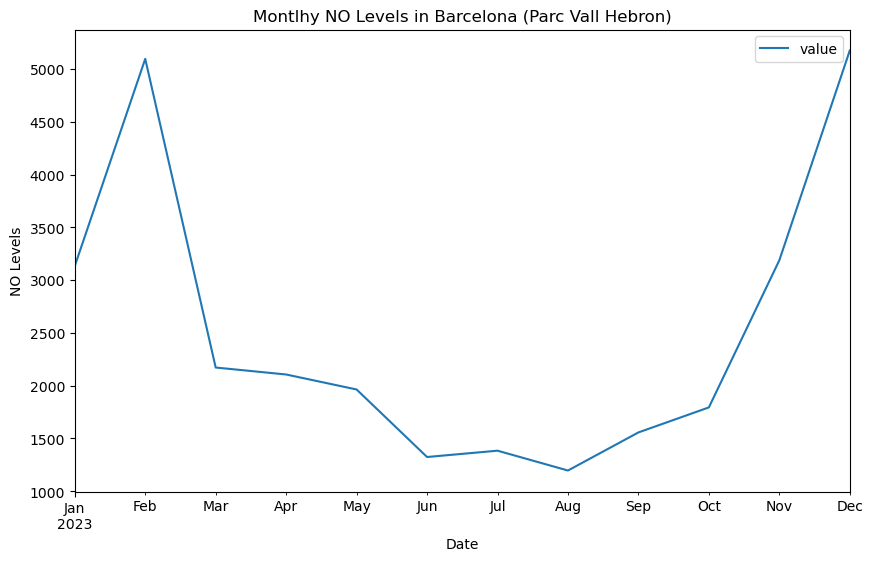

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31   3134
2023-02-28   5097
2023-03-31   2172
2023-04-30   2106
2023-05-31   1964


In [114]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Parc Vall Hebron)', 'NO', 'M')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy NO Levels in Barcelona (Parc Vall Hebron)", "NO Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


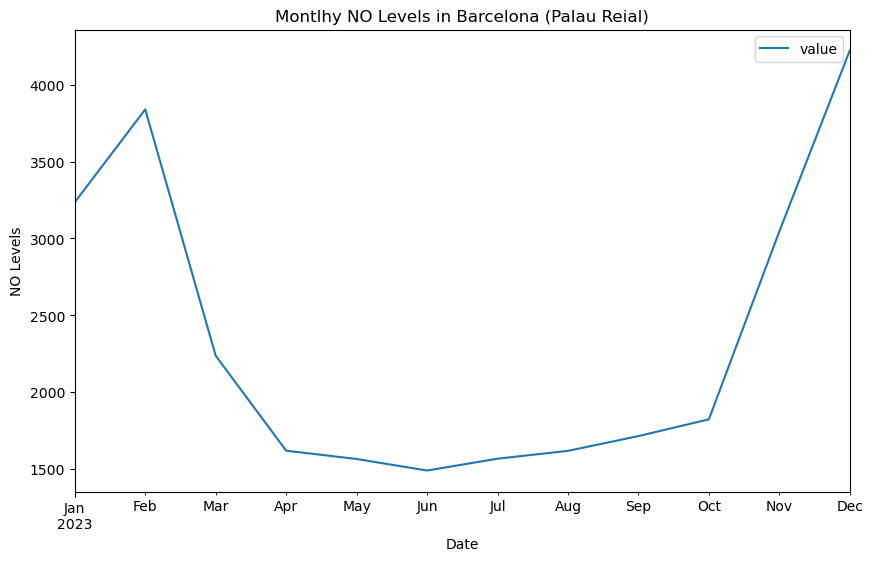

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31   3235
2023-02-28   3839
2023-03-31   2237
2023-04-30   1619
2023-05-31   1565


In [116]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Palau Reial)', 'NO', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy NO Levels in Barcelona (Palau Reial)", "NO Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


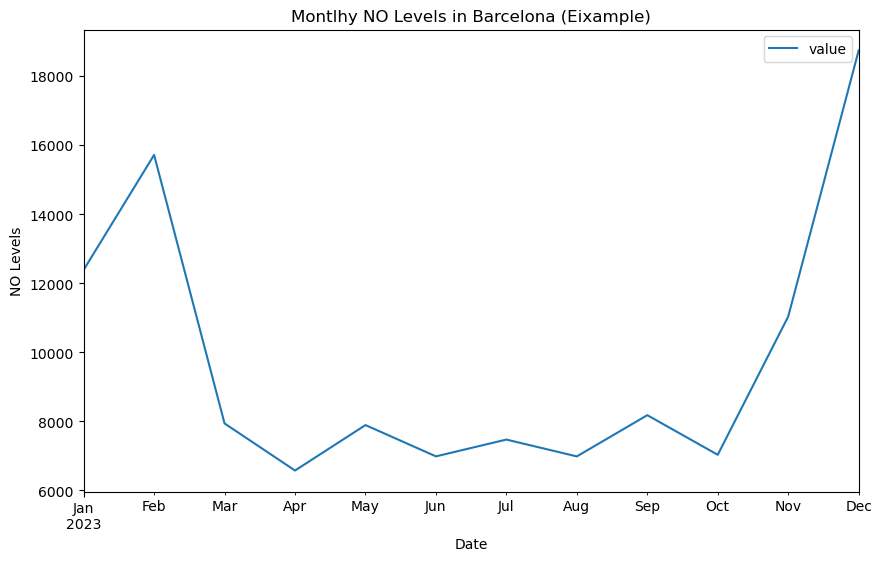

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31  12387
2023-02-28  15718
2023-03-31   7936
2023-04-30   6572
2023-05-31   7889


In [117]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Eixample)', 'NO', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy NO Levels in Barcelona (Eixample)", "NO Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


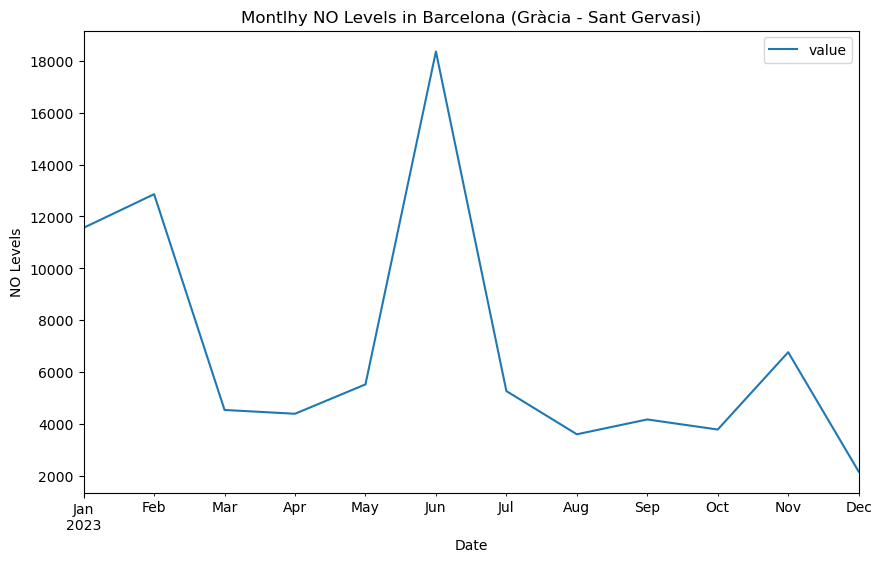

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31  11564
2023-02-28  12859
2023-03-31   4534
2023-04-30   4388
2023-05-31   5521


In [118]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Gràcia - Sant Gervasi)', 'NO', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy NO Levels in Barcelona (Gràcia - Sant Gervasi)", "NO Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


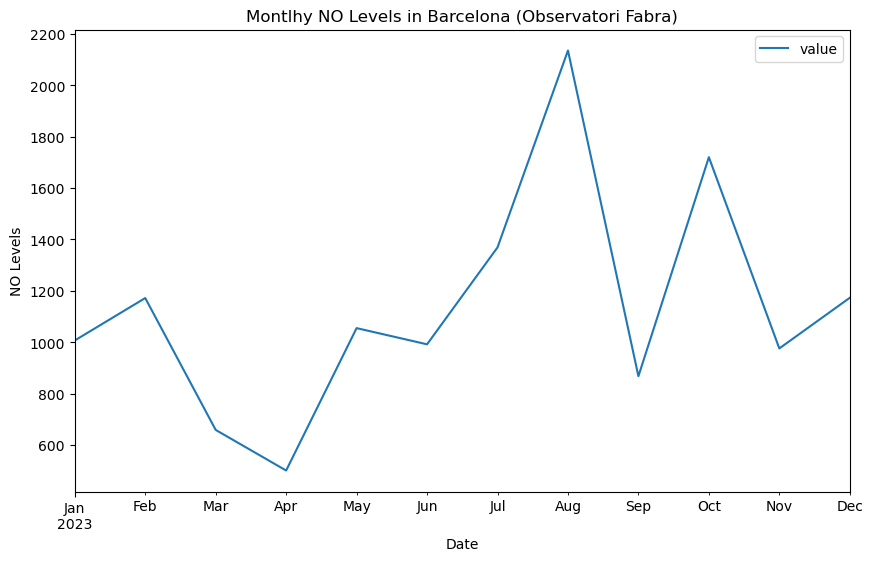

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31   1007
2023-02-28   1172
2023-03-31    659
2023-04-30    501
2023-05-31   1055


In [120]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Observatori Fabra)', 'NO', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy NO Levels in Barcelona (Observatori Fabra)", "NO Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


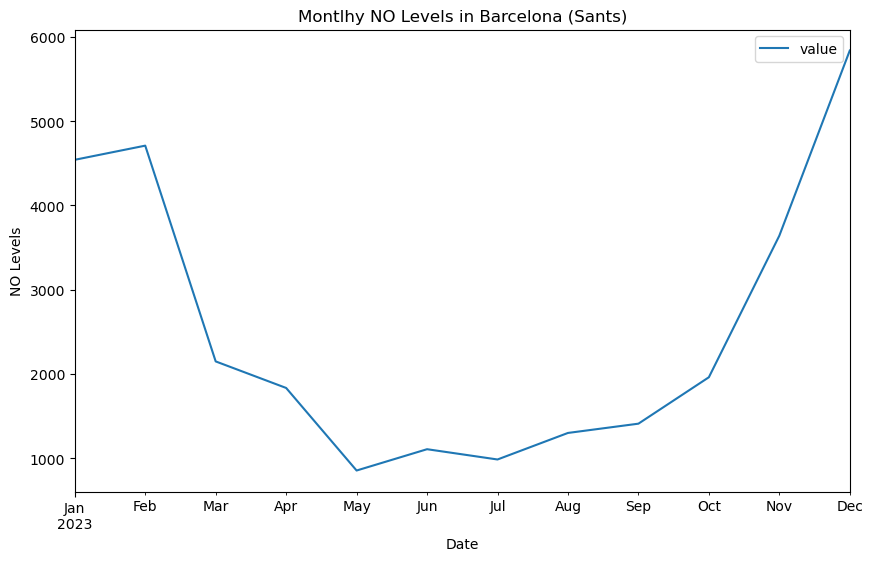

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31   4542
2023-02-28   4710
2023-03-31   2149
2023-04-30   1834
2023-05-31    854


In [121]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Sants)', 'NO', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy NO Levels in Barcelona (Sants)", "NO Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


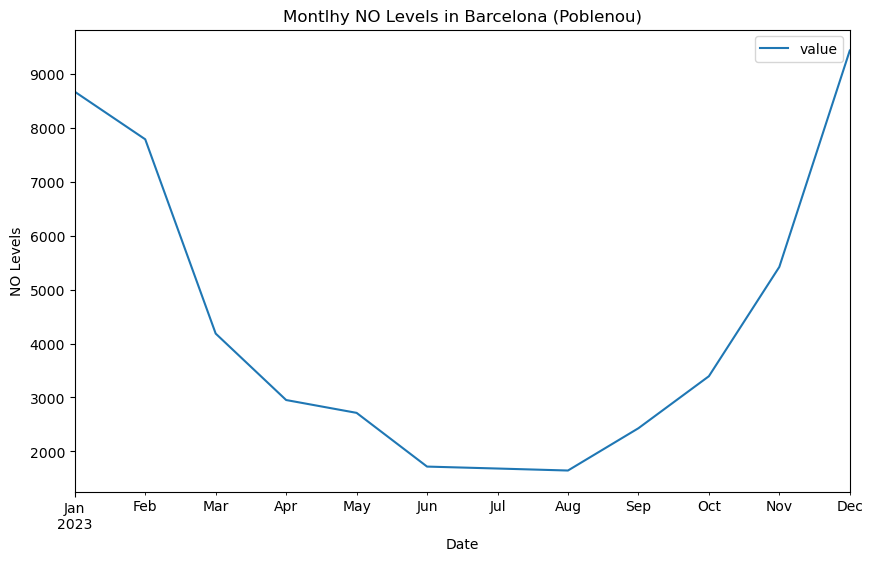

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31   8669
2023-02-28   7787
2023-03-31   4185
2023-04-30   2953
2023-05-31   2715


In [122]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Poblenou)', 'NO', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy NO Levels in Barcelona (Poblenou)", "NO Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


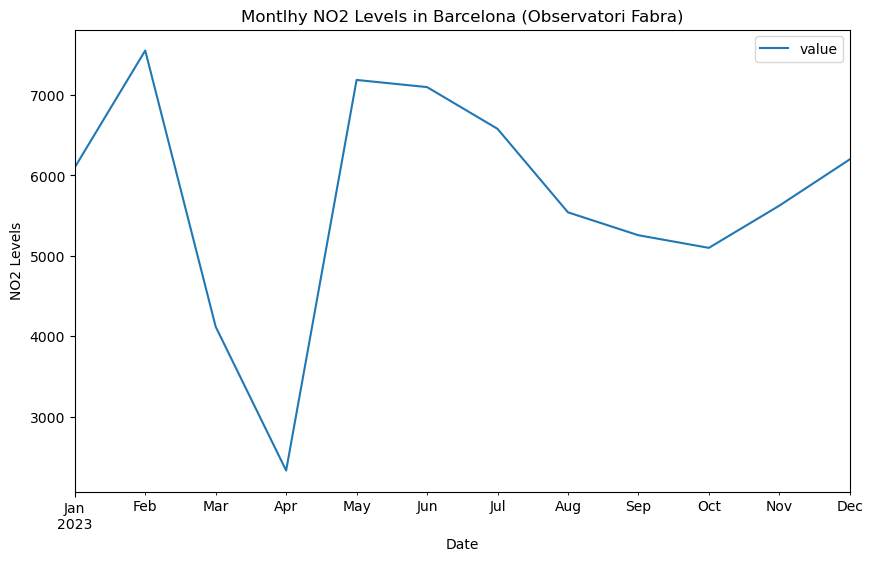

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31   6099
2023-02-28   7553
2023-03-31   4117
2023-04-30   2328
2023-05-31   7187


In [123]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Observatori Fabra)', 'NO2', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy NO2 Levels in Barcelona (Observatori Fabra)", "NO2 Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


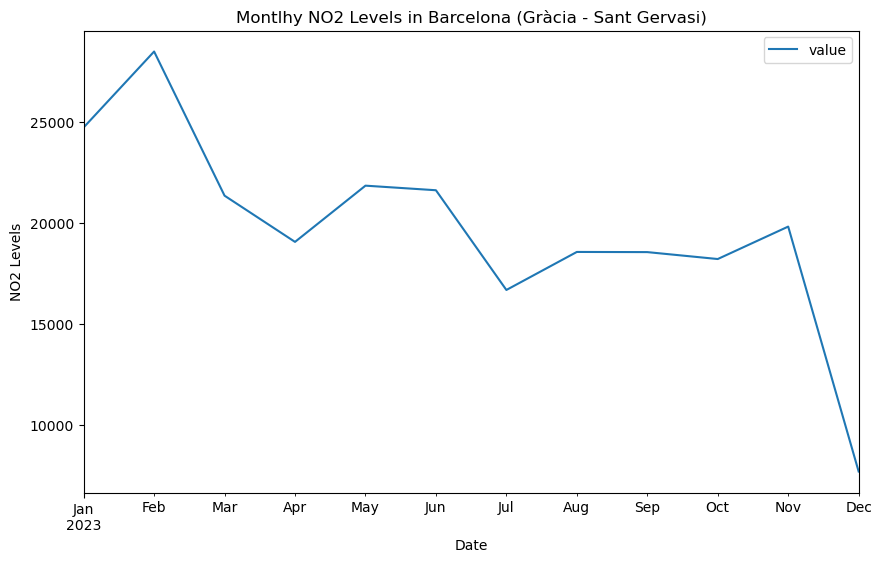

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31  24738
2023-02-28  28499
2023-03-31  21357
2023-04-30  19067
2023-05-31  21853


In [124]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Gràcia - Sant Gervasi)', 'NO2', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy NO2 Levels in Barcelona (Gràcia - Sant Gervasi)", "NO2 Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


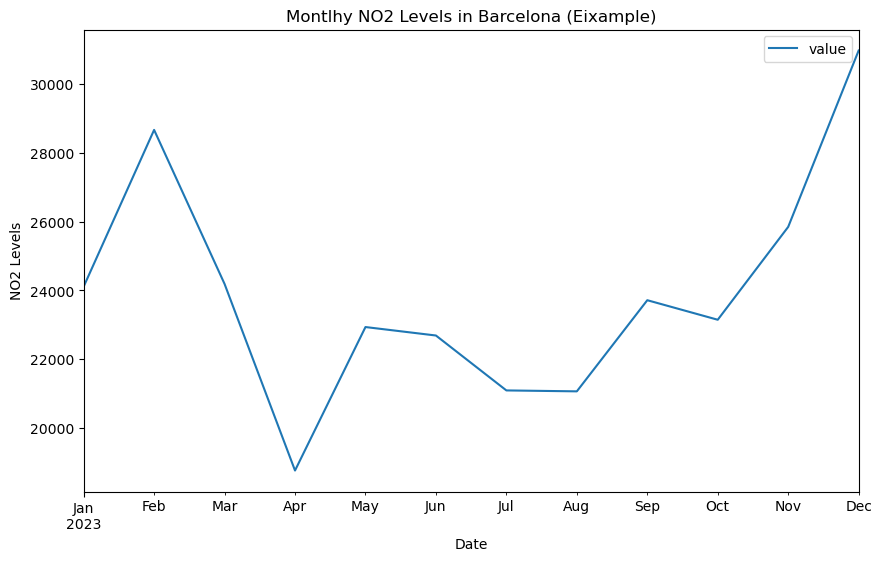

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31  24108
2023-02-28  28664
2023-03-31  24187
2023-04-30  18764
2023-05-31  22934


In [125]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Eixample)', 'NO2', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy NO2 Levels in Barcelona (Eixample)", "NO2 Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


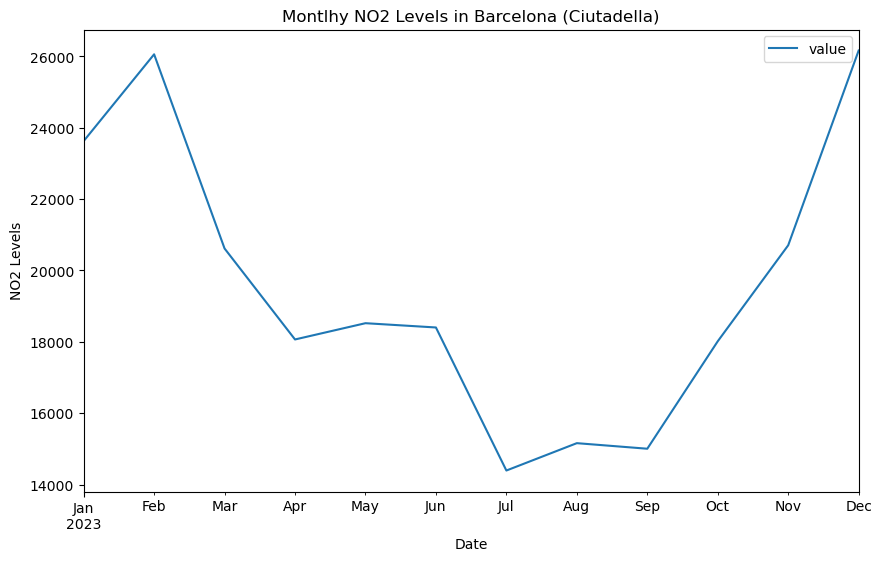

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31  23627
2023-02-28  26060
2023-03-31  20616
2023-04-30  18066
2023-05-31  18522


In [126]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Ciutadella)', 'NO2', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy NO2 Levels in Barcelona (Ciutadella)", "NO2 Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


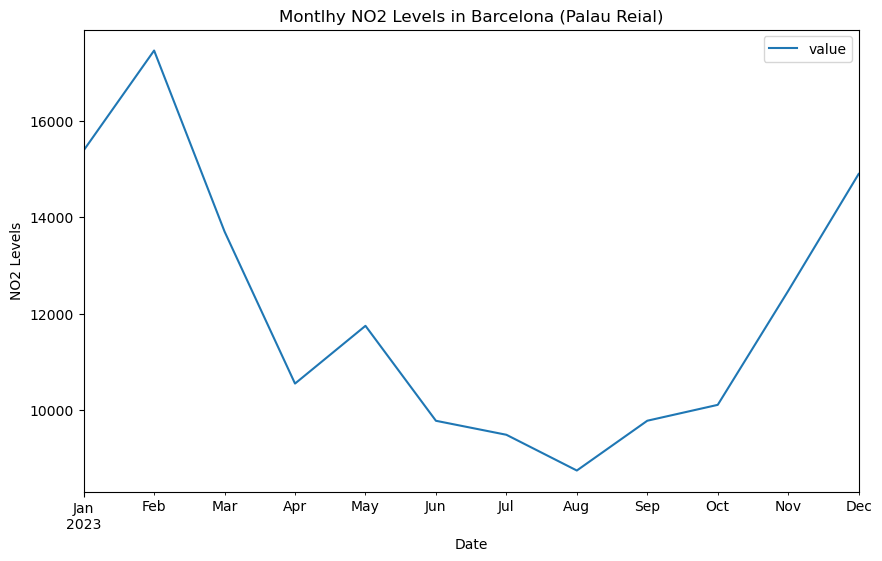

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31  15384
2023-02-28  17454
2023-03-31  13702
2023-04-30  10551
2023-05-31  11748


In [127]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Palau Reial)', 'NO2', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy NO2 Levels in Barcelona (Palau Reial)", "NO2 Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


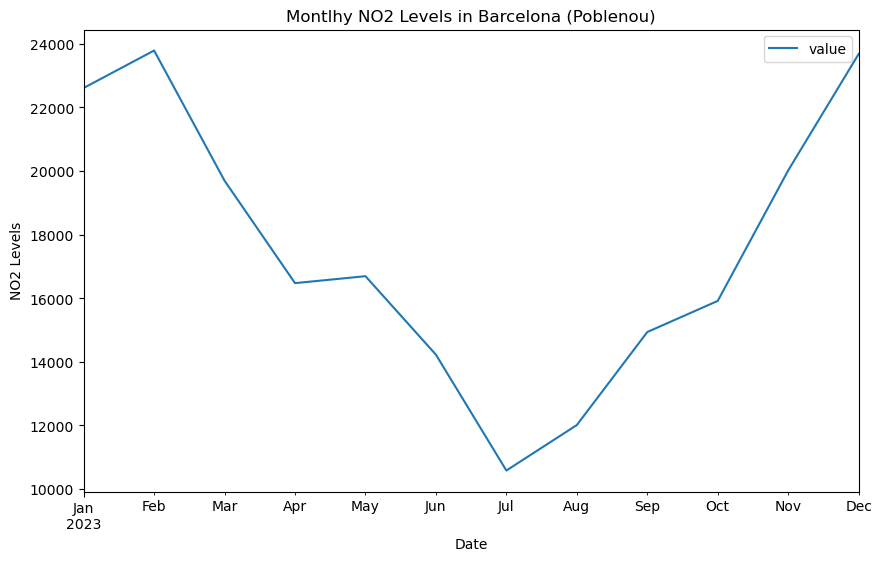

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31  22613
2023-02-28  23791
2023-03-31  19697
2023-04-30  16476
2023-05-31  16694


In [128]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Poblenou)', 'NO2', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy NO2 Levels in Barcelona (Poblenou)", "NO2 Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


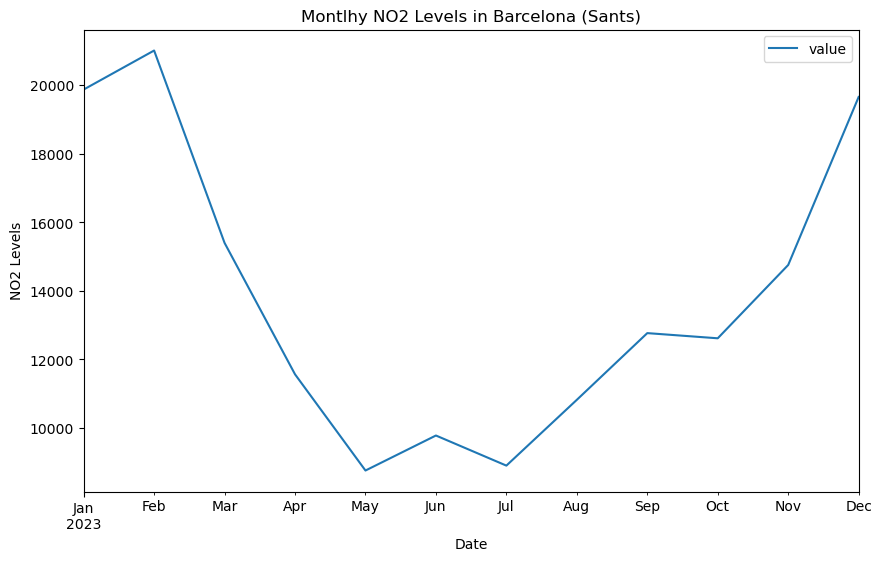

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31  19870
2023-02-28  21008
2023-03-31  15398
2023-04-30  11566
2023-05-31   8760


In [129]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Sants)', 'NO2', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy NO2 Levels in Barcelona (Sants)", "NO2 Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


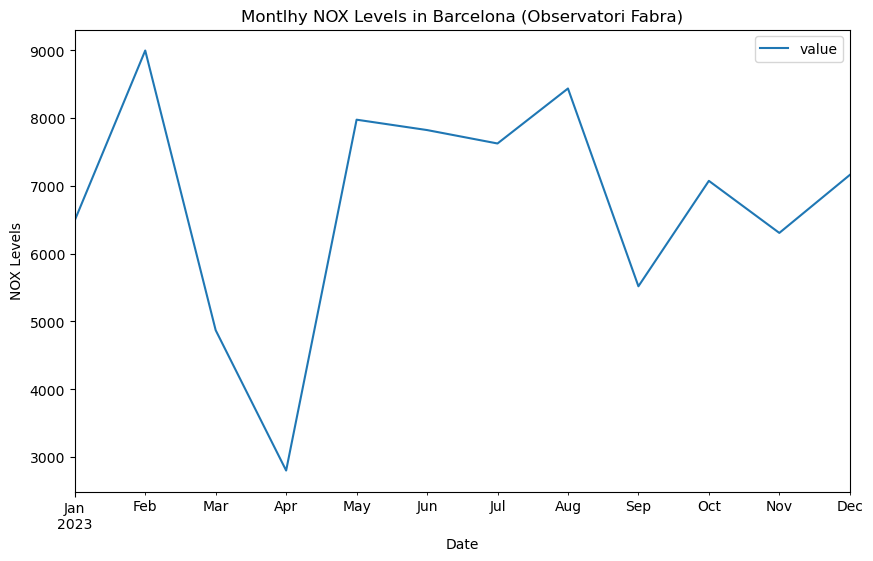

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31   6492
2023-02-28   8996
2023-03-31   4871
2023-04-30   2802
2023-05-31   7976


In [130]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Observatori Fabra)', 'NOX', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy NOX Levels in Barcelona (Observatori Fabra)", "NOX Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


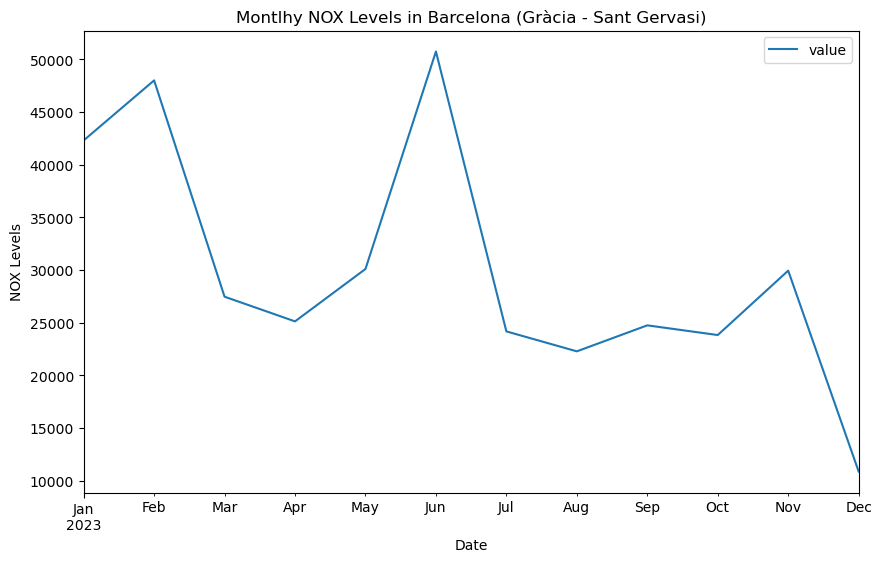

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31  42304
2023-02-28  48002
2023-03-31  27475
2023-04-30  25133
2023-05-31  30106


In [131]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Gràcia - Sant Gervasi)', 'NOX', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy NOX Levels in Barcelona (Gràcia - Sant Gervasi)", "NOX Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


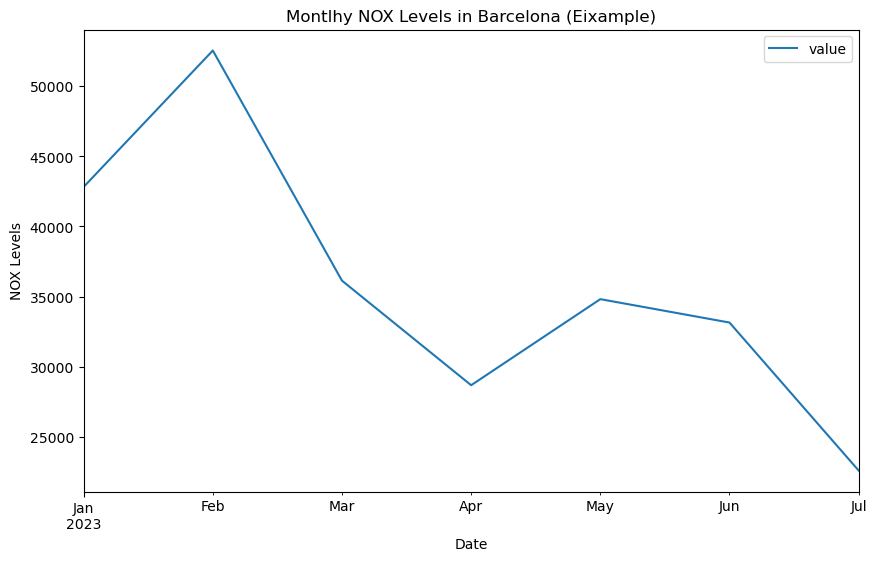

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31  42818
2023-02-28  52530
2023-03-31  36143
2023-04-30  28699
2023-05-31  34827


In [132]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Eixample)', 'NOX', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy NOX Levels in Barcelona (Eixample)", "NOX Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


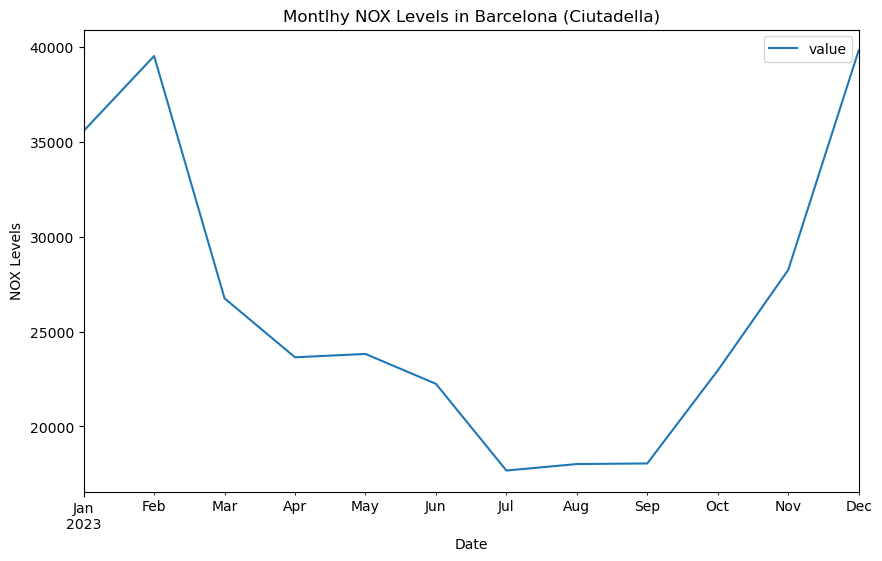

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31  35578
2023-02-28  39528
2023-03-31  26753
2023-04-30  23646
2023-05-31  23823


In [133]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Ciutadella)', 'NOX', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy NOX Levels in Barcelona (Ciutadella)", "NOX Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


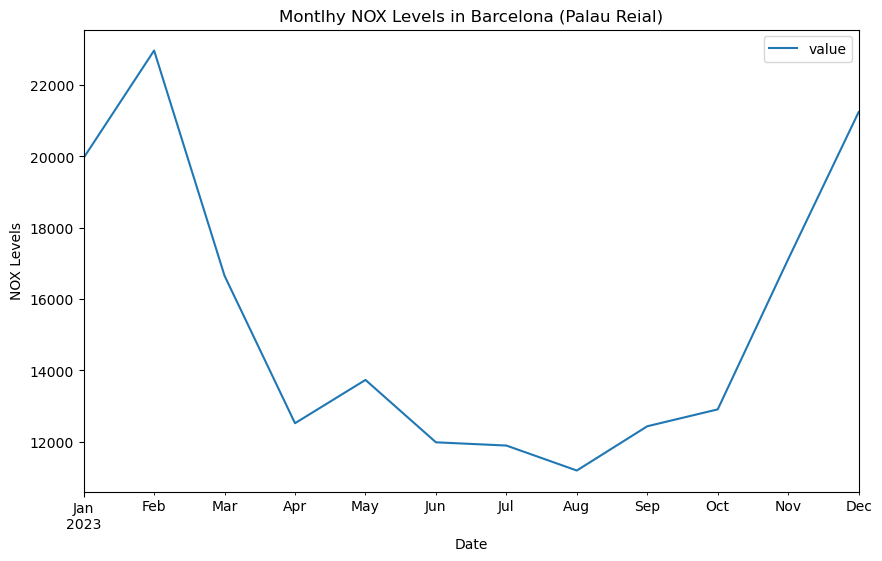

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31  19959
2023-02-28  22968
2023-03-31  16654
2023-04-30  12520
2023-05-31  13734


In [134]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Palau Reial)', 'NOX', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy NOX Levels in Barcelona (Palau Reial)", "NOX Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


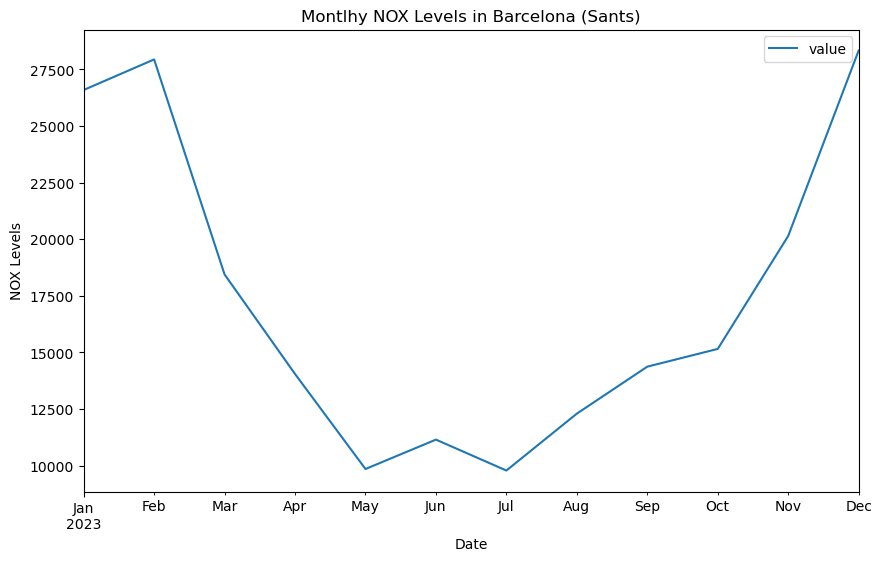

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31  26590
2023-02-28  27940
2023-03-31  18442
2023-04-30  14045
2023-05-31   9846


In [135]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Sants)', 'NOX', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy NOX Levels in Barcelona (Sants)", "NOX Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


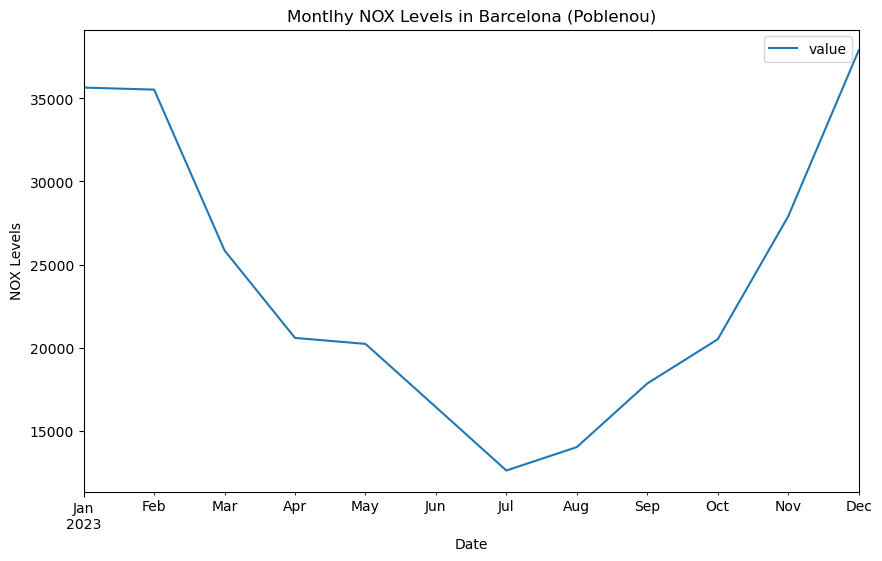

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31  35641
2023-02-28  35518
2023-03-31  25845
2023-04-30  20587
2023-05-31  20230


In [136]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Poblenou)', 'NOX', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy NOX Levels in Barcelona (Poblenou)", "NOX Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


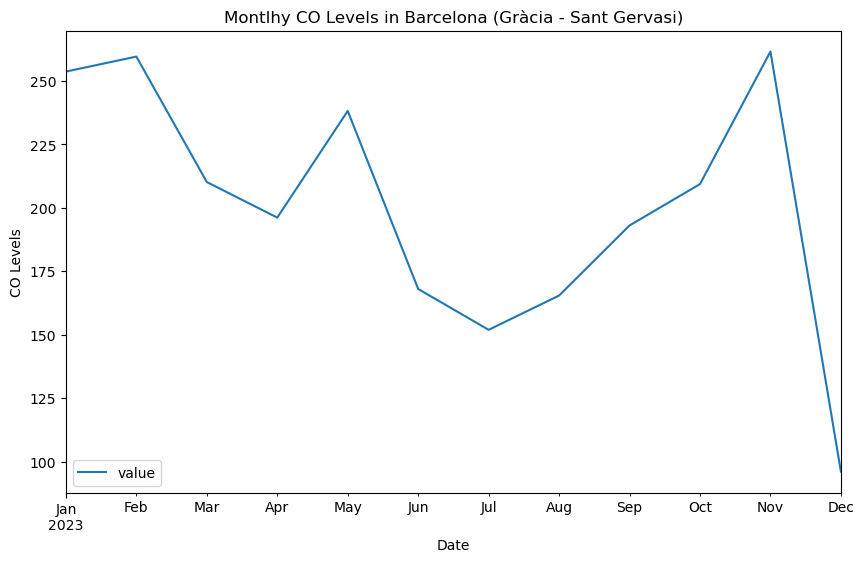

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31  253.6
2023-02-28  259.5
2023-03-31  210.1
2023-04-30  196.1
2023-05-31  238.1


In [139]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Gràcia - Sant Gervasi)', 'CO', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy CO Levels in Barcelona (Gràcia - Sant Gervasi)", "CO Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


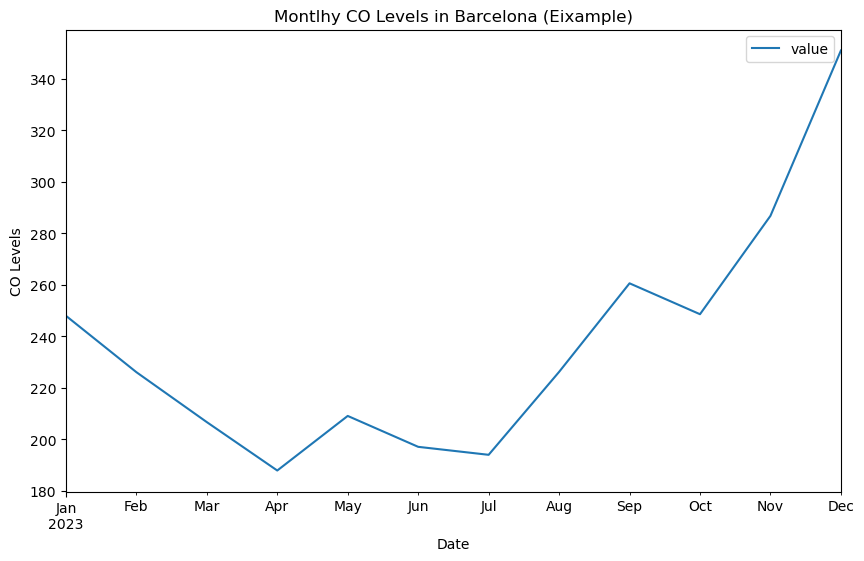

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31  248.0
2023-02-28  226.1
2023-03-31  206.7
2023-04-30  187.9
2023-05-31  209.1


In [140]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Eixample)', 'CO', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy CO Levels in Barcelona (Eixample)", "CO Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


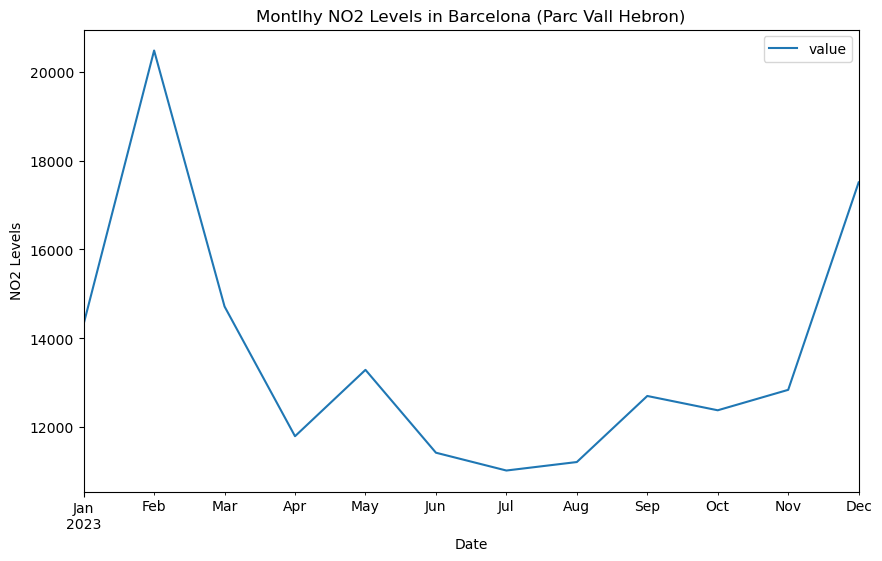

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31  14321
2023-02-28  20476
2023-03-31  14714
2023-04-30  11794
2023-05-31  13288


In [141]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Parc Vall Hebron)', 'NO2', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy NO2 Levels in Barcelona (Parc Vall Hebron)", "NO2 Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


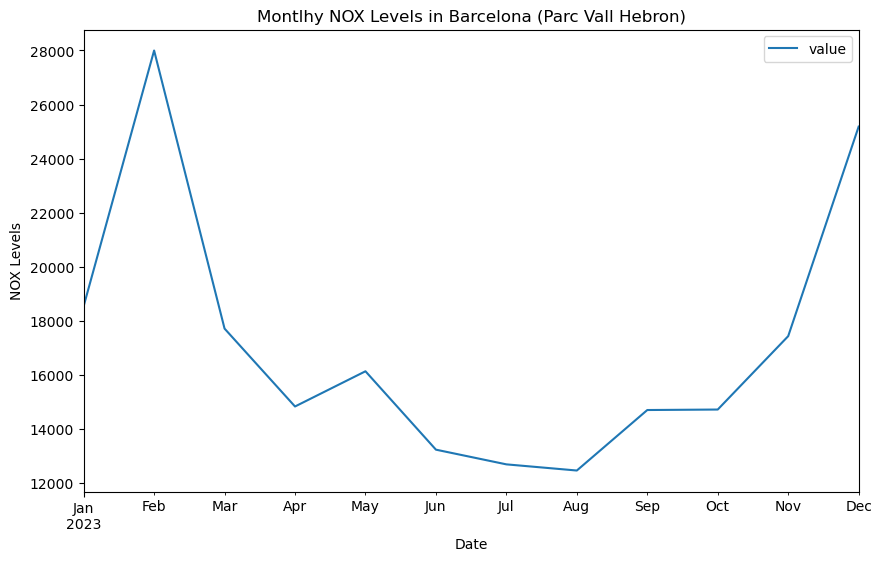

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31  18538
2023-02-28  27999
2023-03-31  17707
2023-04-30  14825
2023-05-31  16128


In [142]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Parc Vall Hebron)', 'NOX', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy NOX Levels in Barcelona (Parc Vall Hebron)", "NOX Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


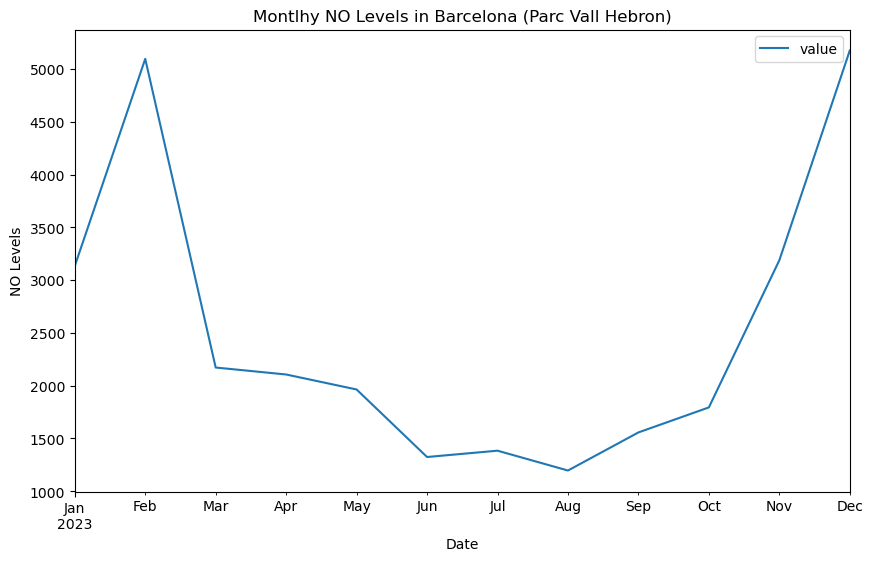

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31   3134
2023-02-28   5097
2023-03-31   2172
2023-04-30   2106
2023-05-31   1964


In [143]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Parc Vall Hebron)', 'NO', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy NO Levels in Barcelona (Parc Vall Hebron)", "NO Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


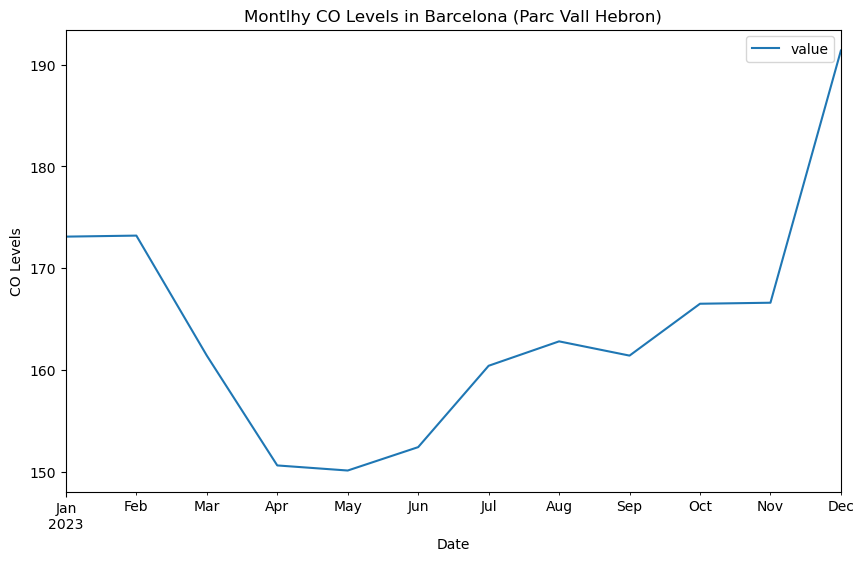

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31  173.1
2023-02-28  173.2
2023-03-31  161.4
2023-04-30  150.6
2023-05-31  150.1


In [144]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Parc Vall Hebron)', 'CO', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy CO Levels in Barcelona (Parc Vall Hebron)", "CO Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


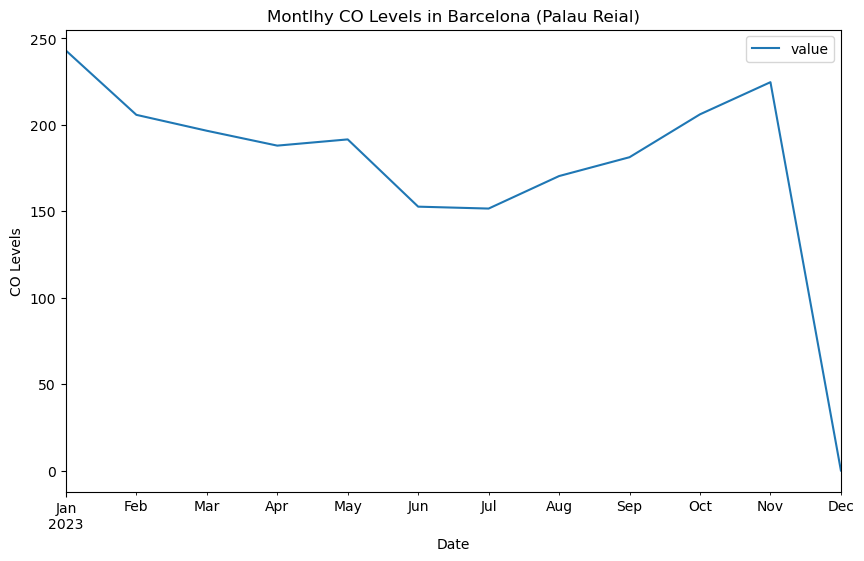

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31  242.9
2023-02-28  205.7
2023-03-31  196.5
2023-04-30  187.9
2023-05-31  191.5


In [145]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Palau Reial)', 'CO', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy CO Levels in Barcelona (Palau Reial)", "CO Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


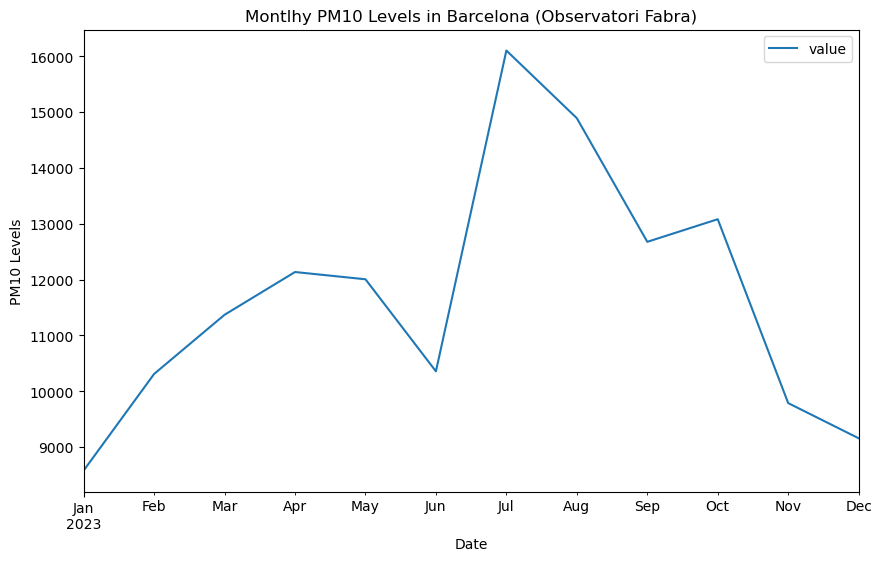

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31   8580
2023-02-28  10310
2023-03-31  11370
2023-04-30  12136
2023-05-31  12006


In [146]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Observatori Fabra)', 'PM10', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy PM10 Levels in Barcelona (Observatori Fabra)", "PM10 Levels")
    print(processed_data.head())
    print(resampled.head())

In [ ]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Parc Vall Hebron)', 'NOX', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy NOX Levels in Barcelona (Parc Vall Hebron)", "NOX Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


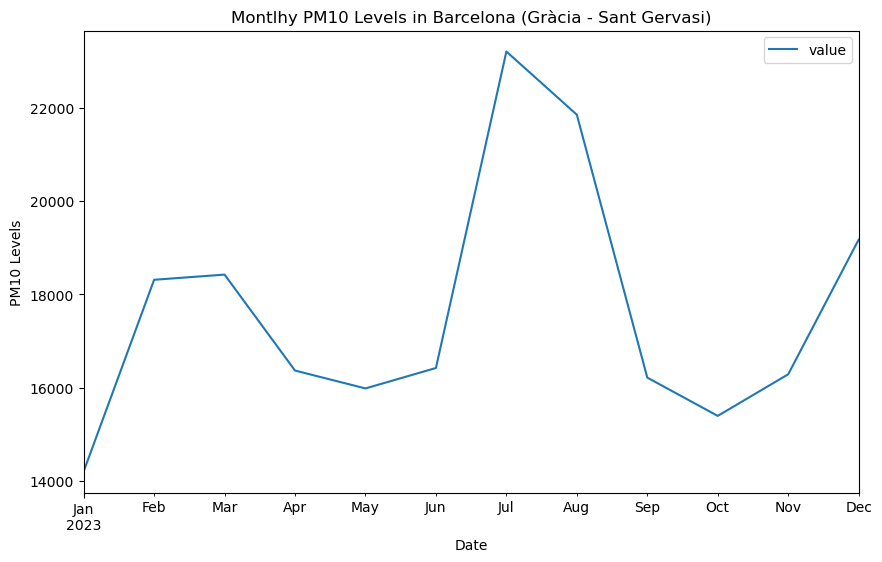

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31  14202
2023-02-28  18314
2023-03-31  18425
2023-04-30  16367
2023-05-31  15984


In [148]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Gràcia - Sant Gervasi)', 'PM10', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy PM10 Levels in Barcelona (Gràcia - Sant Gervasi)", "PM10 Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


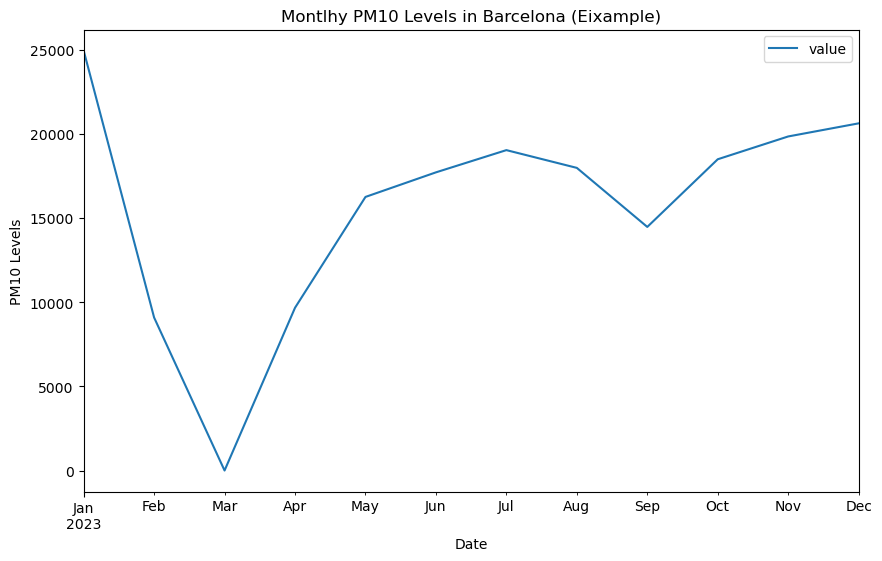

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31  24955
2023-02-28   9091
2023-03-31      0
2023-04-30   9670
2023-05-31  16256


In [149]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Eixample)', 'PM10', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy PM10 Levels in Barcelona (Eixample)", "PM10 Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


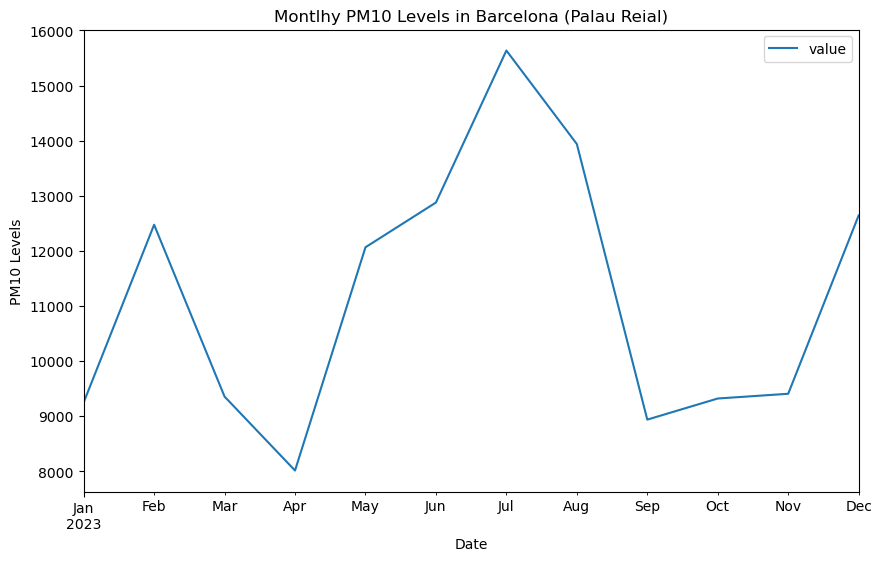

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31   9248
2023-02-28  12474
2023-03-31   9355
2023-04-30   8013
2023-05-31  12065


In [150]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Palau Reial)', 'PM10', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy PM10 Levels in Barcelona (Palau Reial)", "PM10 Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


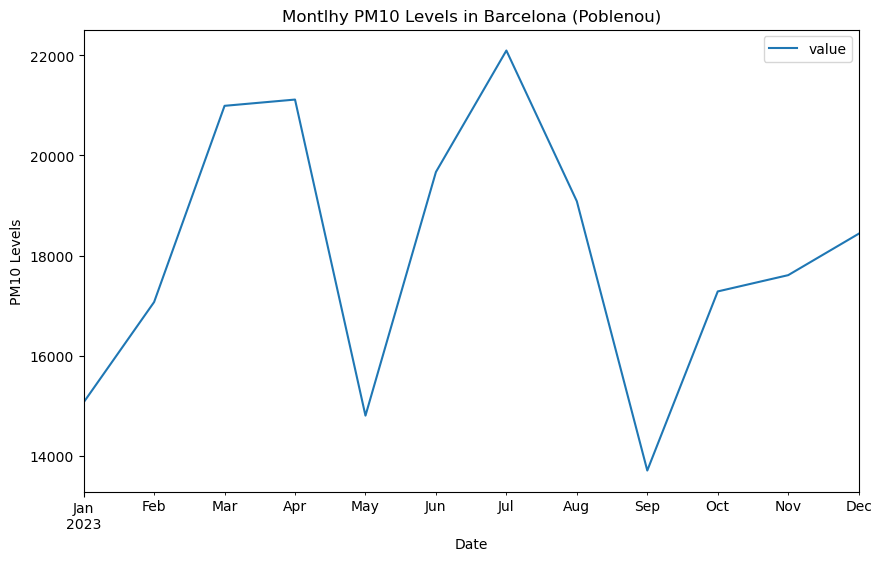

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31  15071
2023-02-28  17073
2023-03-31  20990
2023-04-30  21115
2023-05-31  14806


In [151]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Poblenou)', 'PM10', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy PM10 Levels in Barcelona (Poblenou)", "PM10 Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


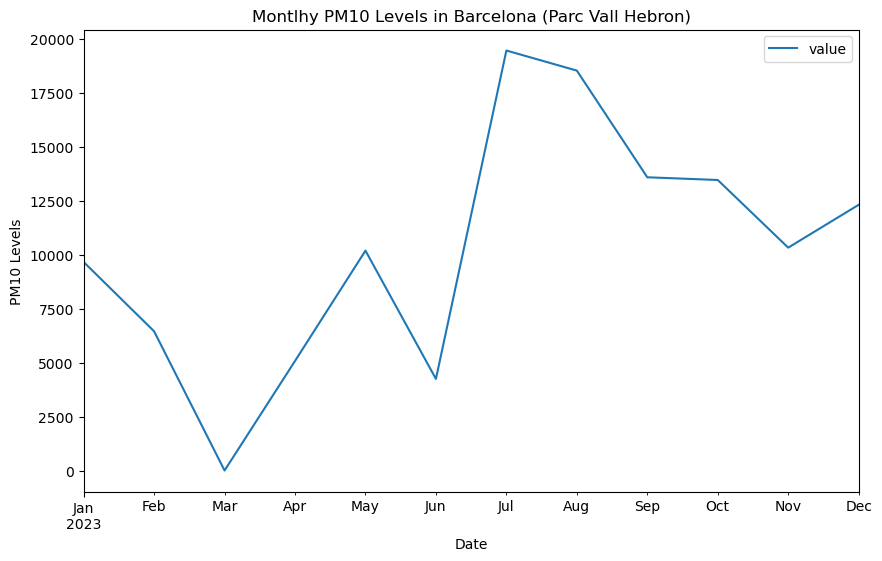

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31   9661
2023-02-28   6450
2023-03-31      0
2023-04-30   5076
2023-05-31  10188


In [152]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Parc Vall Hebron)', 'PM10', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy PM10 Levels in Barcelona (Parc Vall Hebron)", "PM10 Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


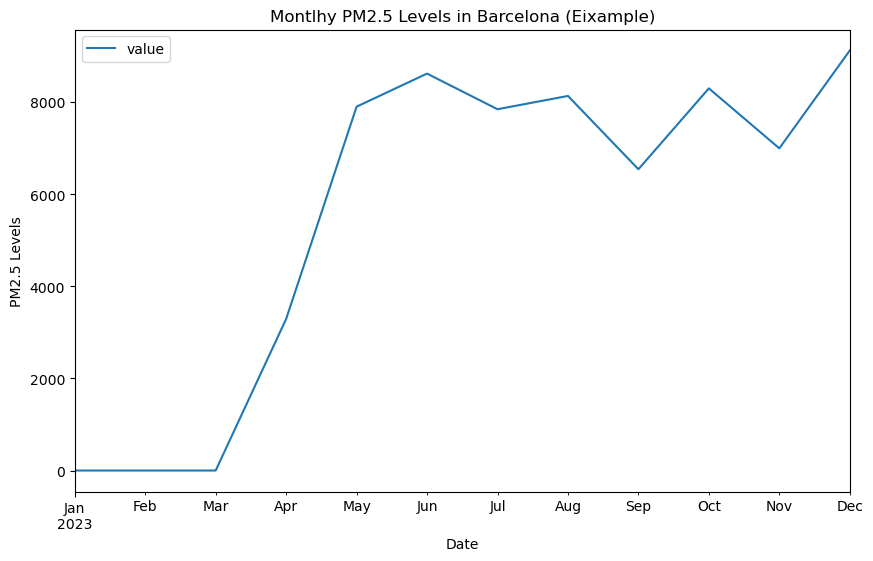

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31      0
2023-02-28      0
2023-03-31      0
2023-04-30   3291
2023-05-31   7901


In [153]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Eixample)', 'PM2.5', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy PM2.5 Levels in Barcelona (Eixample)", "PM2.5 Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


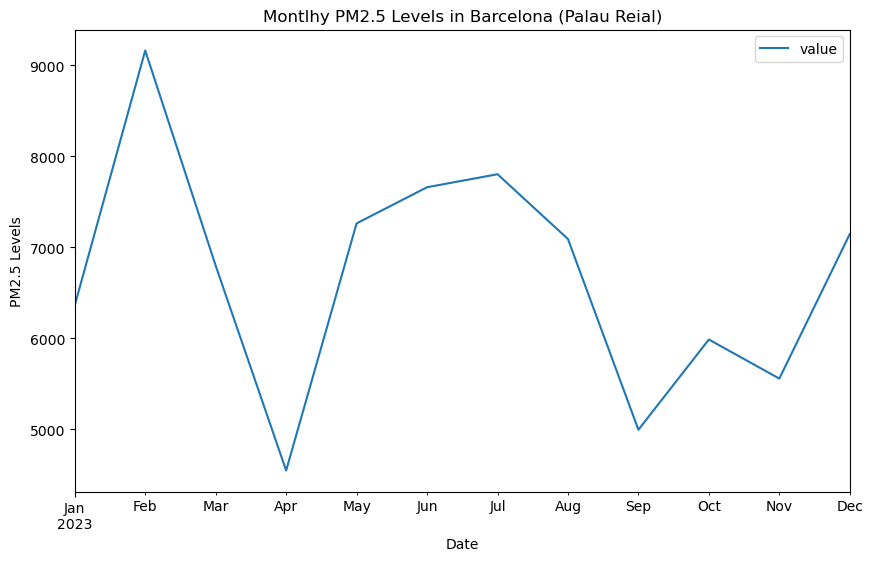

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            value
data             
2023-01-31   6365
2023-02-28   9163
2023-03-31   6799
2023-04-30   4549
2023-05-31   7264


In [167]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Palau Reial)', 'PM2.5', 'ME')
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries(resampled, "Montlhy PM2.5 Levels in Barcelona (Palau Reial)", "PM2.5 Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
279324 2020-01-01 01:00:00               Barcelona (Eixample)        PM10   
279305 2020-01-01 01:00:00       Barcelona (Parc Vall Hebron)         NOX   
279303 2020-01-01 01:00:00            Barcelona (Palau Reial)         SO2   
279325 2020-01-01 01:00:00       Barcelona (Parc Vall Hebron)         SO2   
279326 2020-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)         NO2   

       value  
279324    26  
279305    82  
279303     2  
279325     2  
279326    53  


C:\Users\diogo\AppData\Local\Temp\ipykernel_9472\3177487272.py:67: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  resampled = numeric_data.resample(frequency, on='data').sum()
C:\Users\diogo\AppData\Local\Temp\ipykernel_9472\3177487272.py:67: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  resampled = numeric_data.resample(frequency, on='data').sum()


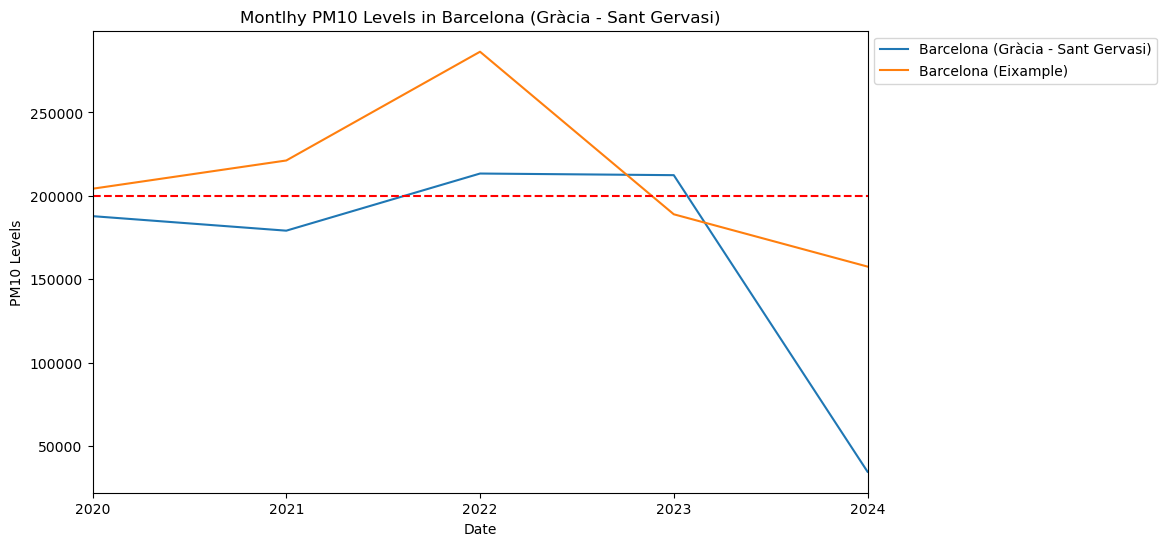

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            Barcelona (Gràcia - Sant Gervasi)
data                                         
2020-12-31                             187867
2021-12-31                             179164
2022-12-31                             213397
2023-12-31                             212420
2024-12-31                              34746


In [277]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2020-01-01') & (processed_data['data'] < '2024-10-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Gràcia - Sant Gervasi)', 'PM10', 'Y')
    resampled.rename(columns = {'value' : 'Barcelona (Gràcia - Sant Gervasi)'}, inplace=True)

    resampled_1 = accumulate_data(filtered_df, 'Barcelona (Eixample)', 'PM10', 'Y')
    resampled_1.rename(columns = {'value' : 'Barcelona (Eixample)'}, inplace=True)
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries_2(resampled, resampled_1, "Montlhy PM10 Levels in Barcelona (Gràcia - Sant Gervasi)", "PM10 Levels")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


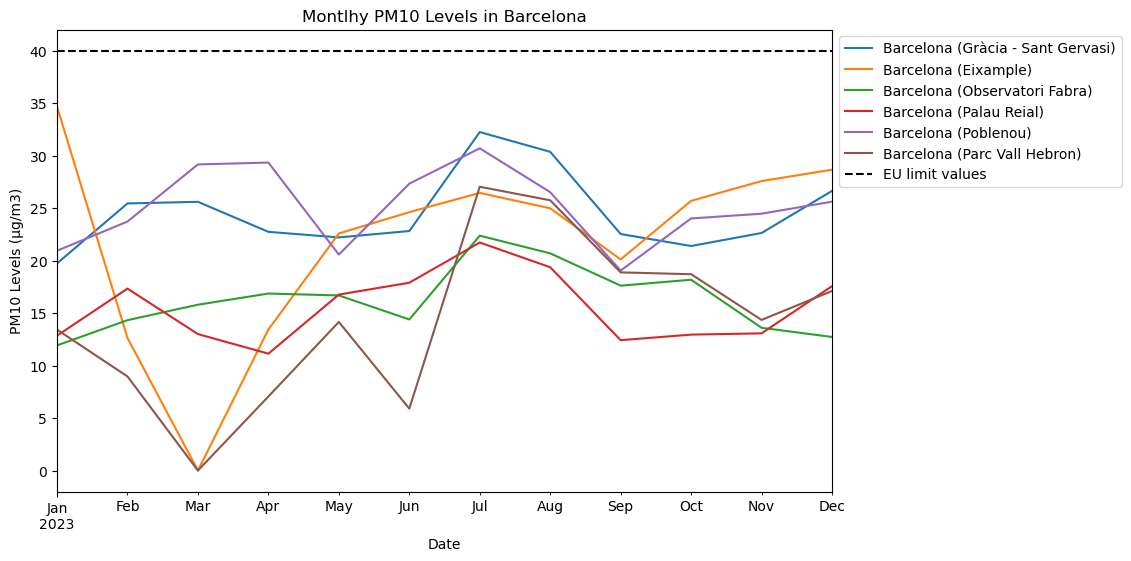

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            Barcelona (Gràcia - Sant Gervasi)
data                                         
2023-01-31                              14202
2023-02-28                              18314
2023-03-31                              18425
2023-04-30                              16367
2023-05-31                              15984


In [300]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Gràcia - Sant Gervasi)', 'PM10', 'ME')
    resampled.rename(columns = {'value' : 'Barcelona (Gràcia - Sant Gervasi)'}, inplace=True)
    resampled_1 = accumulate_data(filtered_df, 'Barcelona (Eixample)', 'PM10', 'ME')
    resampled_1.rename(columns = {'value' : 'Barcelona (Eixample)'}, inplace=True)
    resampled_2 = accumulate_data(filtered_df, 'Barcelona (Observatori Fabra)', 'PM10', 'ME')
    resampled_2.rename(columns = {'value' : 'Barcelona (Observatori Fabra)'}, inplace=True)
    resampled_3 = accumulate_data(filtered_df, 'Barcelona (Palau Reial)', 'PM10', 'ME')
    resampled_3.rename(columns = {'value' : 'Barcelona (Palau Reial)'}, inplace=True)
    resampled_4 = accumulate_data(filtered_df, 'Barcelona (Poblenou)', 'PM10', 'ME')
    resampled_4.rename(columns = {'value' : 'Barcelona (Poblenou)'}, inplace=True)
    resampled_5 = accumulate_data(filtered_df, 'Barcelona (Parc Vall Hebron)', 'PM10', 'ME')
    resampled_5.rename(columns = {'value' : 'Barcelona (Parc Vall Hebron)'}, inplace=True)
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries_6(resampled/720, resampled_1/720, resampled_2/720, resampled_3/720, resampled_4/720, resampled_5/720, "Montlhy PM10 Levels in Barcelona", "PM10 Levels (μg/m3)")
    print(processed_data.head())
    print(resampled.head())

                      data                        nom_estacio contaminant  \
230619 2023-01-01 01:00:00             Barcelona (Ciutadella)         NOX   
230620 2023-01-01 01:00:00            Barcelona (Palau Reial)        PM10   
230612 2023-01-01 01:00:00  Barcelona (Gràcia - Sant Gervasi)          NO   
230613 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          CO   
230614 2023-01-01 01:00:00       Barcelona (Parc Vall Hebron)          NO   

       value  
230619   128  
230620    33  
230612    81  
230613   0.5  
230614     7  


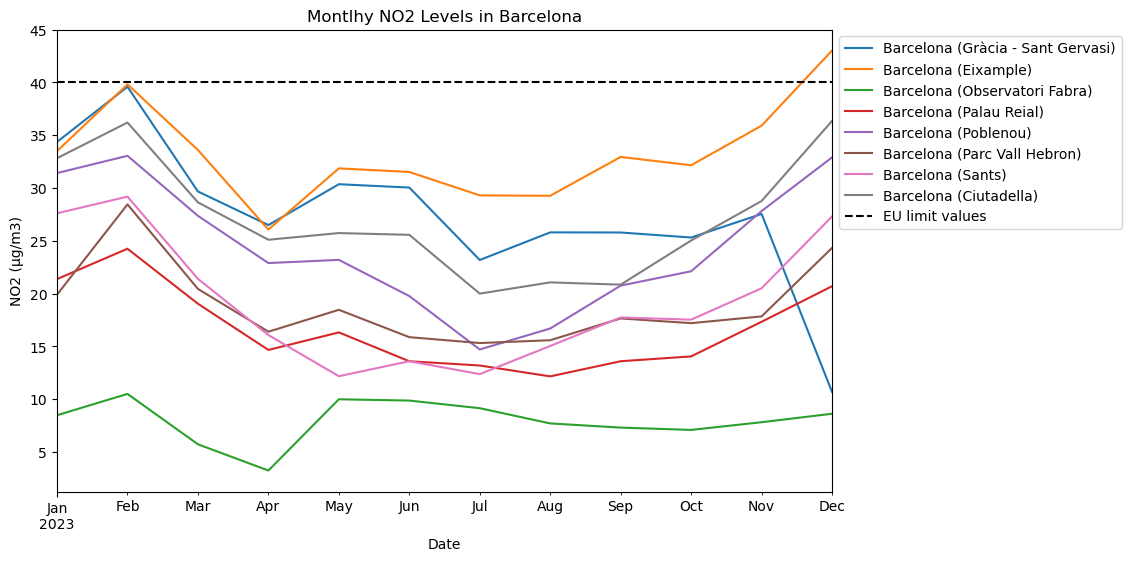

             data                   nom_estacio contaminant value
199994 2011-02-07  Barcelona (Parc Vall Hebron)         SO2     0
199999 2011-02-07          Barcelona (Eixample)         NO2    96
199998 2011-02-07          Barcelona (Eixample)         NOX   261
199995 2011-02-07      Barcelona (Torre Girona)         SO2     1
199996 2011-02-07             Barcelona (Sants)         NOX   162
            Barcelona (Gràcia - Sant Gervasi)
data                                         
2023-01-31                              24738
2023-02-28                              28499
2023-03-31                              21357
2023-04-30                              19067
2023-05-31                              21853


In [301]:
if __name__ == "__main__":
    fetcher = DataFetcher("analisi.transparenciacatalunya.cat", "9Hbf461pXC6Lin1yqkq414Fxi", "tasf-thgu")
    
    #processed_data = fetcher.process_and_save_data("municipi='Barcelona'", output_file = 'data_from_barcelona.csv') # you collect and save all the data in a file 
    processsed_data = pd.read_csv("data_from_barcelona.csv")
    
    filtered_df = processed_data.loc[(processed_data['data'] > '2023-01-01') & (processed_data['data'] < '2023-12-31')]
    print(filtered_df.head())

    resampled = accumulate_data(filtered_df, 'Barcelona (Gràcia - Sant Gervasi)', 'NO2', 'ME')
    resampled.rename(columns = {'value' : 'Barcelona (Gràcia - Sant Gervasi)'}, inplace=True)
    resampled_1 = accumulate_data(filtered_df, 'Barcelona (Eixample)', 'NO2', 'ME')
    resampled_1.rename(columns = {'value' : 'Barcelona (Eixample)'}, inplace=True)
    resampled_2 = accumulate_data(filtered_df, 'Barcelona (Observatori Fabra)', 'NO2', 'ME')
    resampled_2.rename(columns = {'value' : 'Barcelona (Observatori Fabra)'}, inplace=True)
    resampled_3 = accumulate_data(filtered_df, 'Barcelona (Palau Reial)', 'NO2', 'ME')
    resampled_3.rename(columns = {'value' : 'Barcelona (Palau Reial)'}, inplace=True)
    resampled_4 = accumulate_data(filtered_df, 'Barcelona (Poblenou)', 'NO2', 'ME')
    resampled_4.rename(columns = {'value' : 'Barcelona (Poblenou)'}, inplace=True)
    resampled_5 = accumulate_data(filtered_df, 'Barcelona (Parc Vall Hebron)', 'NO2', 'ME')
    resampled_5.rename(columns = {'value' : 'Barcelona (Parc Vall Hebron)'}, inplace=True)
    resampled_6 = accumulate_data(filtered_df, 'Barcelona (Sants)', 'NO2', 'ME')
    resampled_6.rename(columns = {'value' : 'Barcelona (Sants)'}, inplace=True)
    resampled_7 = accumulate_data(filtered_df, 'Barcelona (Ciutadella)', 'NO2', 'ME')
    resampled_7.rename(columns = {'value' : 'Barcelona (Ciutadella)'}, inplace=True)
    #resampled_daily = resampled.groupby(resampled.index.date).sum()
    plot_timeseries_8(resampled/720, resampled_1/720, resampled_2/720, resampled_3/720, resampled_4/720, resampled_5/720, resampled_6/720, resampled_7/720, "Montlhy NO2 Levels in Barcelona", "NO2 (μg/m3)")
    print(processed_data.head())
    print(resampled.head())